# 0.0 Importações

## 0.1 Importando bibliotecas

In [261]:
#manipulação de dados
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Calculos
import math
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#utilidades
import inflection
from IPython.display import Image
import datetime

#Machine learning
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

## 0.2 Carregando os dados

In [5]:
df_vendas_raw = pd.read_csv("archive/train.csv", low_memory=False)
df_lojas_raw = pd.read_csv("archive/store.csv", low_memory=False)
#o parâmetro low memory indica que o seu pc tem pouca memoria, e a funcao le o arquivo por chunks

#merge
df_raw = pd.merge(df_vendas_raw, df_lojas_raw, how="left", on="Store")

In [6]:
df_raw.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

## 1.1 Renomeando colunas

In [9]:
df1 = df_raw.copy()

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#trocar as palavras para snakecase onde elas são separadas por underlines
snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 Dimensões dos dados

In [12]:
print(f"Linhas: {df1.shape[0]}")
print(f"Colunas: {df1.shape[1]}")

Linhas: 1017209
Colunas: 18


## 1.3 Tipo das colunas

In [14]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Checagem de N/As

In [17]:
df1.isna().sum() #/ df1.shape[0] #porcentagem

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchendo NAs

In [19]:
#competition_distance -> trocar por uma distancia maior do que exista no dataset para indicar que não h'a competidores

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month -> vamos usar a data de abertura da loja para indicar

df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x['competition_open_since_month'], axis=1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x['competition_open_since_year'], axis=1)

#promo2_since_week -> se for NA, a loja não participou da promoção, vamos colocar a data do date, e na feature engeneering vamos remover

df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x['promo2_since_week'], axis=1)

#promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x['promo2_since_year'], axis=1)



In [20]:
#promo_interval
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1['promo_interval'].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map(month_map) #Tradução da data em mês para indicar se a loja estava em promoção

In [21]:
df1['is_promo'] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis=1)

In [22]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## 1.6 Mudança nos tipos

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype( int )
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype( int )

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [26]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descrição dos dados

In [28]:
df_num = df1.select_dtypes( include=["int64", "float64"] )
df_cat = df1.select_dtypes( exclude=["int64", "float64", "datetime64[ns]"] )

### 1.7.1 Dados numéricos

In [30]:
medias = pd.DataFrame( df_num.apply( np.mean ) ).T #.t serve para transpor
medianas = pd.DataFrame( df_num.apply( np.median ) ).T 

In [31]:
desvio_padrao = pd.DataFrame( df_num.apply( np.std ) ).T
minimo = pd.DataFrame( df_num.apply( min ) ).T
maximo = pd.DataFrame( df_num.apply( max ) ).T
intervalo = pd.DataFrame( df_num.apply(lambda x: x.max() - x.min()) ).T
skew = pd.DataFrame( df_num.apply( lambda x: x.skew())).T #Quanto mais pr'oxima a 0, mais tende a curva normal
kurtosis = pd.DataFrame( df_num.apply(lambda x: x.kurtosis() ) ).T

In [32]:
metricas_numericas = pd.concat( [minimo, maximo, intervalo, medias, medianas, desvio_padrao, skew, kurtosis] ).T.reset_index()
metricas_numericas.columns = (["atributos","minimo","maximo","intervalo","medias","medianas","desvio_padrao","skew","kurtosis"])

In [33]:
metricas_numericas

,atributos,minimo,maximo,intervalo,medias,medianas,desvio_padrao,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Count'>

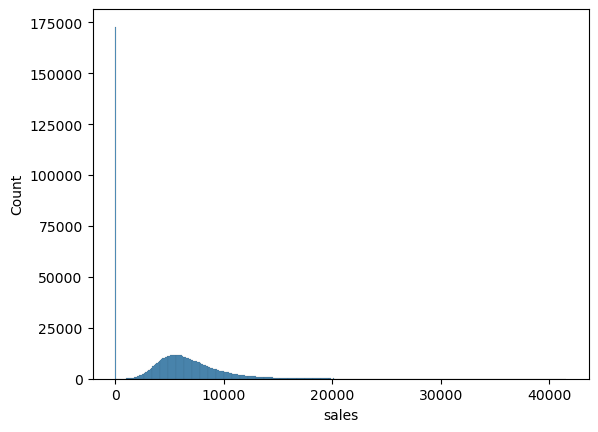

In [34]:
sns.histplot(df_num["sales"])

### 1.7.2 Dados categoricos

In [36]:
df_cat.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

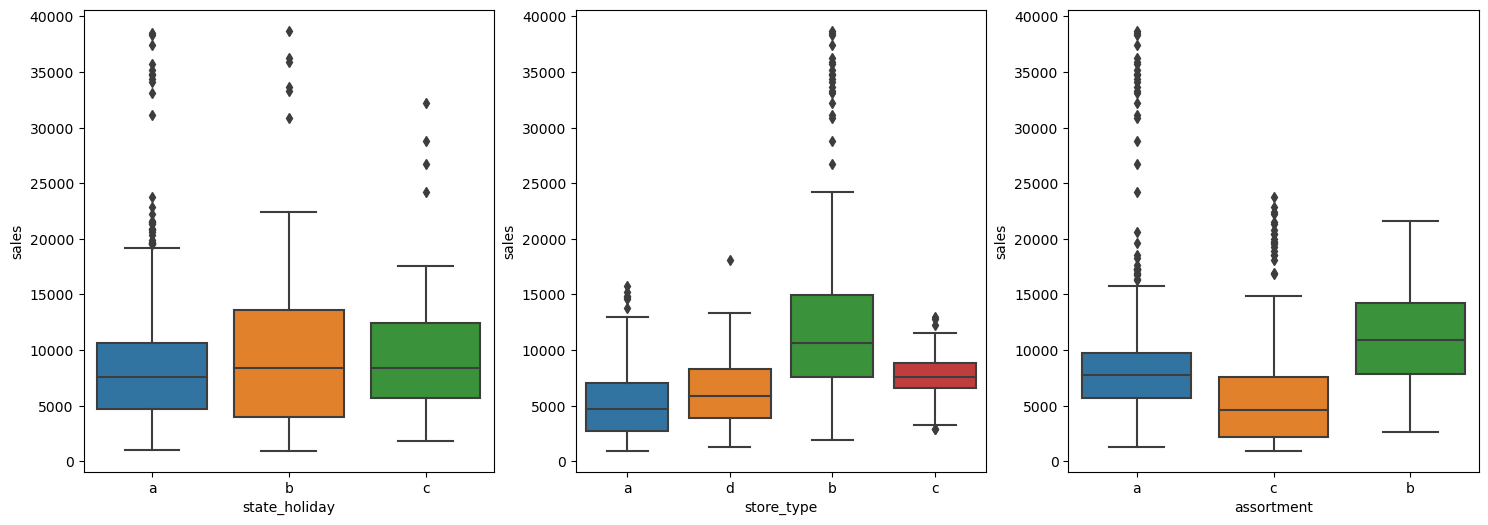

In [37]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
sns.boxplot(x = "state_holiday", y = "sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = "store_type", y = "sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = "assortment", y = "sales", data=aux1)

# 2.0 Feature Engeneering

In [39]:
df2 = df1.copy()

## 2.1 Mapa mental de hipoteses

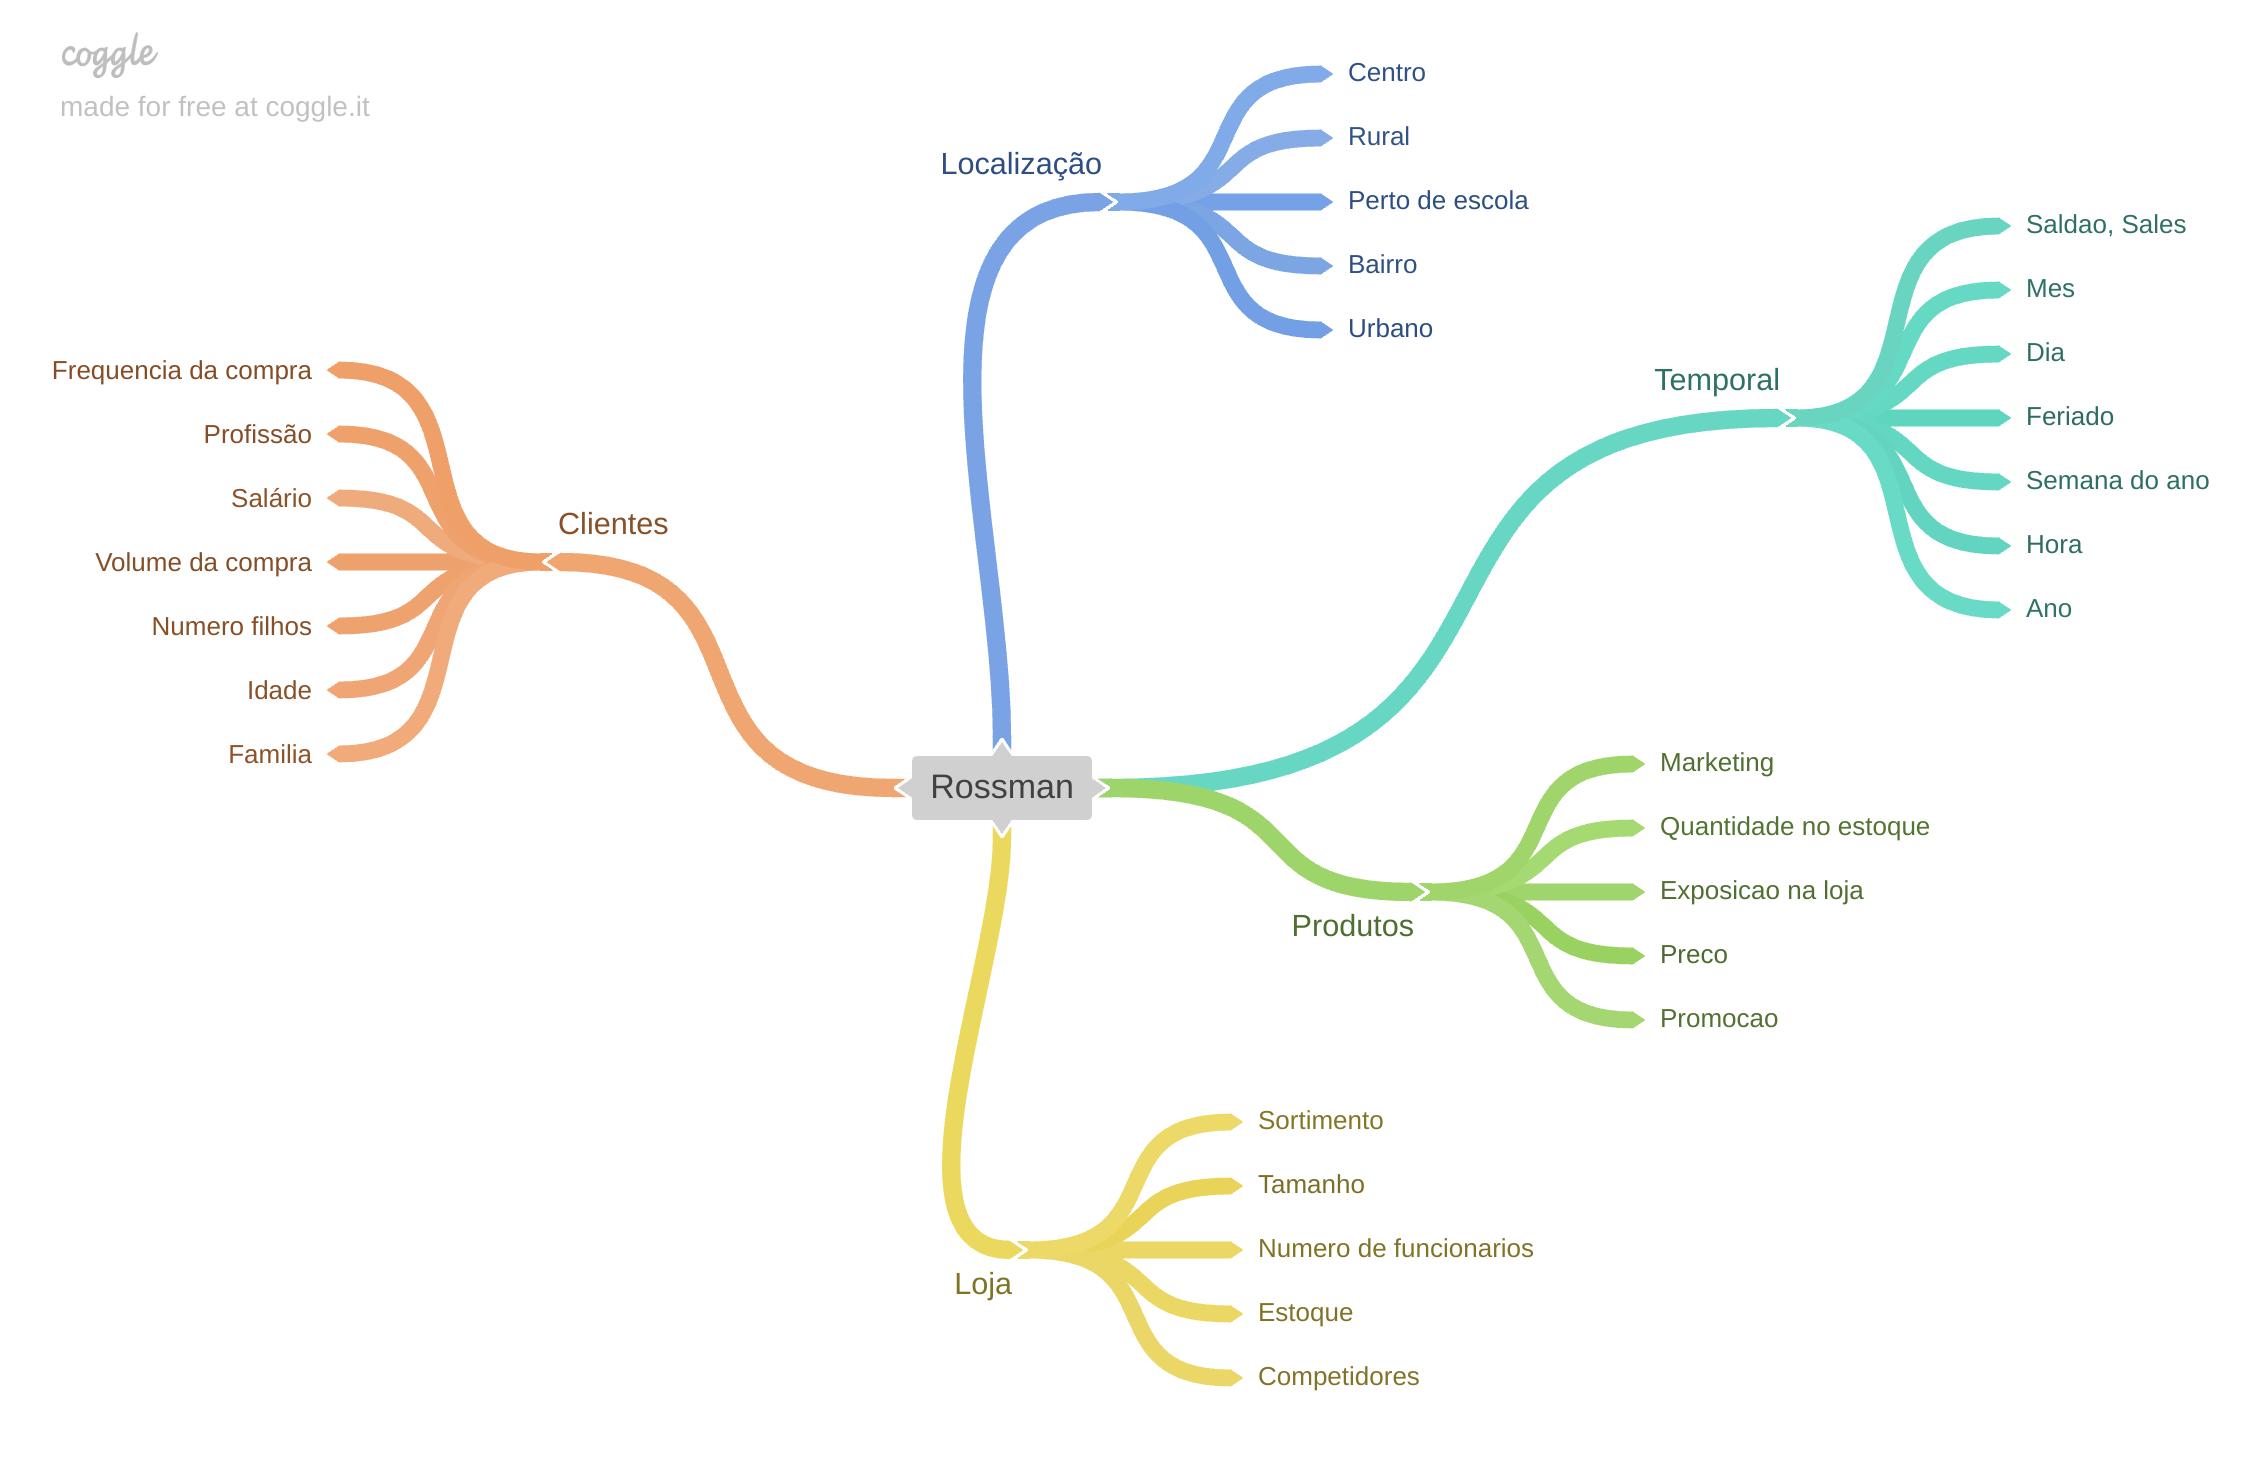

In [41]:
Image("images/Rossman-mindmap.png")

## 2.2 Criação das Hipoteses

### 2.2.1 Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses de produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses sobre o tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista final de hipoteses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas a mais tempo deveriam vender mais

**5.** Lojas com promoções consecutivas deveriam vender mais

**6.** Lojas abertas durante o natal deveriam vender mais

**7.** Lojas deveriam vender mais ao longo dos anos

**8.** Lojas deveriam vender mais no segundo semestre do ano

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês

**10.** Lojas deveriam vender menos aos finais de semana

**11.** Lojas deveriam vender menos durante feriados escolares

## 2.5 Derivação de features

In [52]:
# Ano
df2['year'] = df2['date'].dt.year

# Mês
df2['month'] = df2['date'].dt.month

# Dia
df2['day'] = df2['date'].dt.day

# Semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#ano e semana
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype( int )

#promo since
df2['promo_since']=df2["promo2_since_year"].astype(str) + '-' + df2["promo2_since_week"].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', "%Y-%W-%w") - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x == 'c' else 'regular_day')

In [53]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de variaveis
pensar nas restrições de negócios antes de dar deploy no projeto

In [55]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [57]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


- open: deve ser diferente de 0
- sales: deve ser maior do que 0

In [59]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

- customers: removido pois não podemos saber quantos customers estarão na loja nas próximas 6 
- open: depois do filtro so vai ter um valor
- promo_interval: coluna auxiliar
- month_map: coluna auxiliar

In [62]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

#  4.0 Analise exploratoria de dados

In [64]:
df4 = df3.copy()

## 4.1 Analise univariada

### 4.1.1 Analise da variavel resposta

<Axes: xlabel='sales', ylabel='Count'>

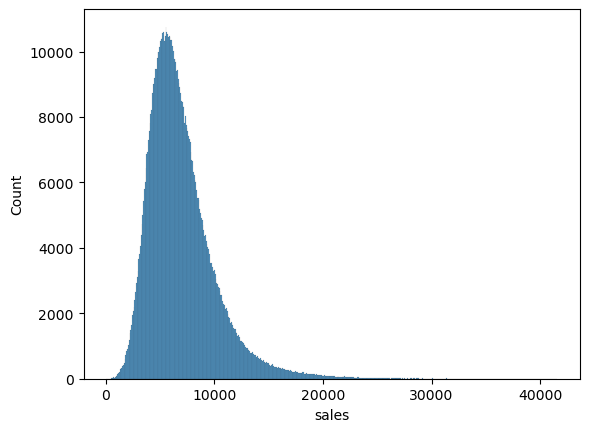

In [67]:
sns.histplot( df4['sales'])

### 4.1.2 Analise de numéricas

<Figure size 2500x2000 with 0 Axes>

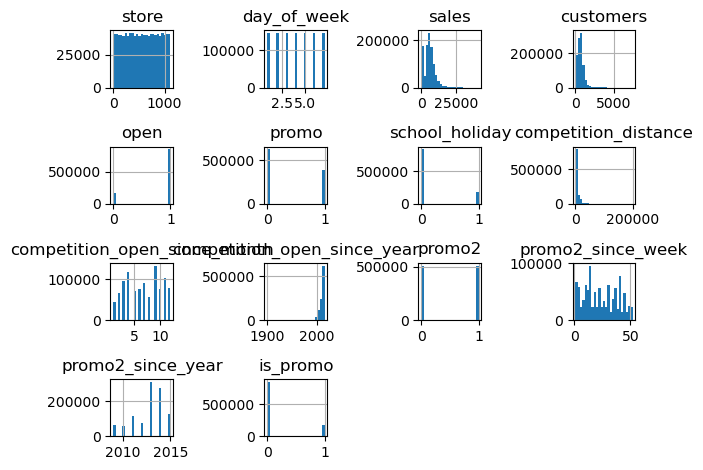

In [69]:
plt.figure(figsize=(25, 20))
df_num.hist(bins = 25);
plt.tight_layout()
plt.show()

### 4.1.3 Analise de categoricas

In [71]:
df_cat.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [72]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

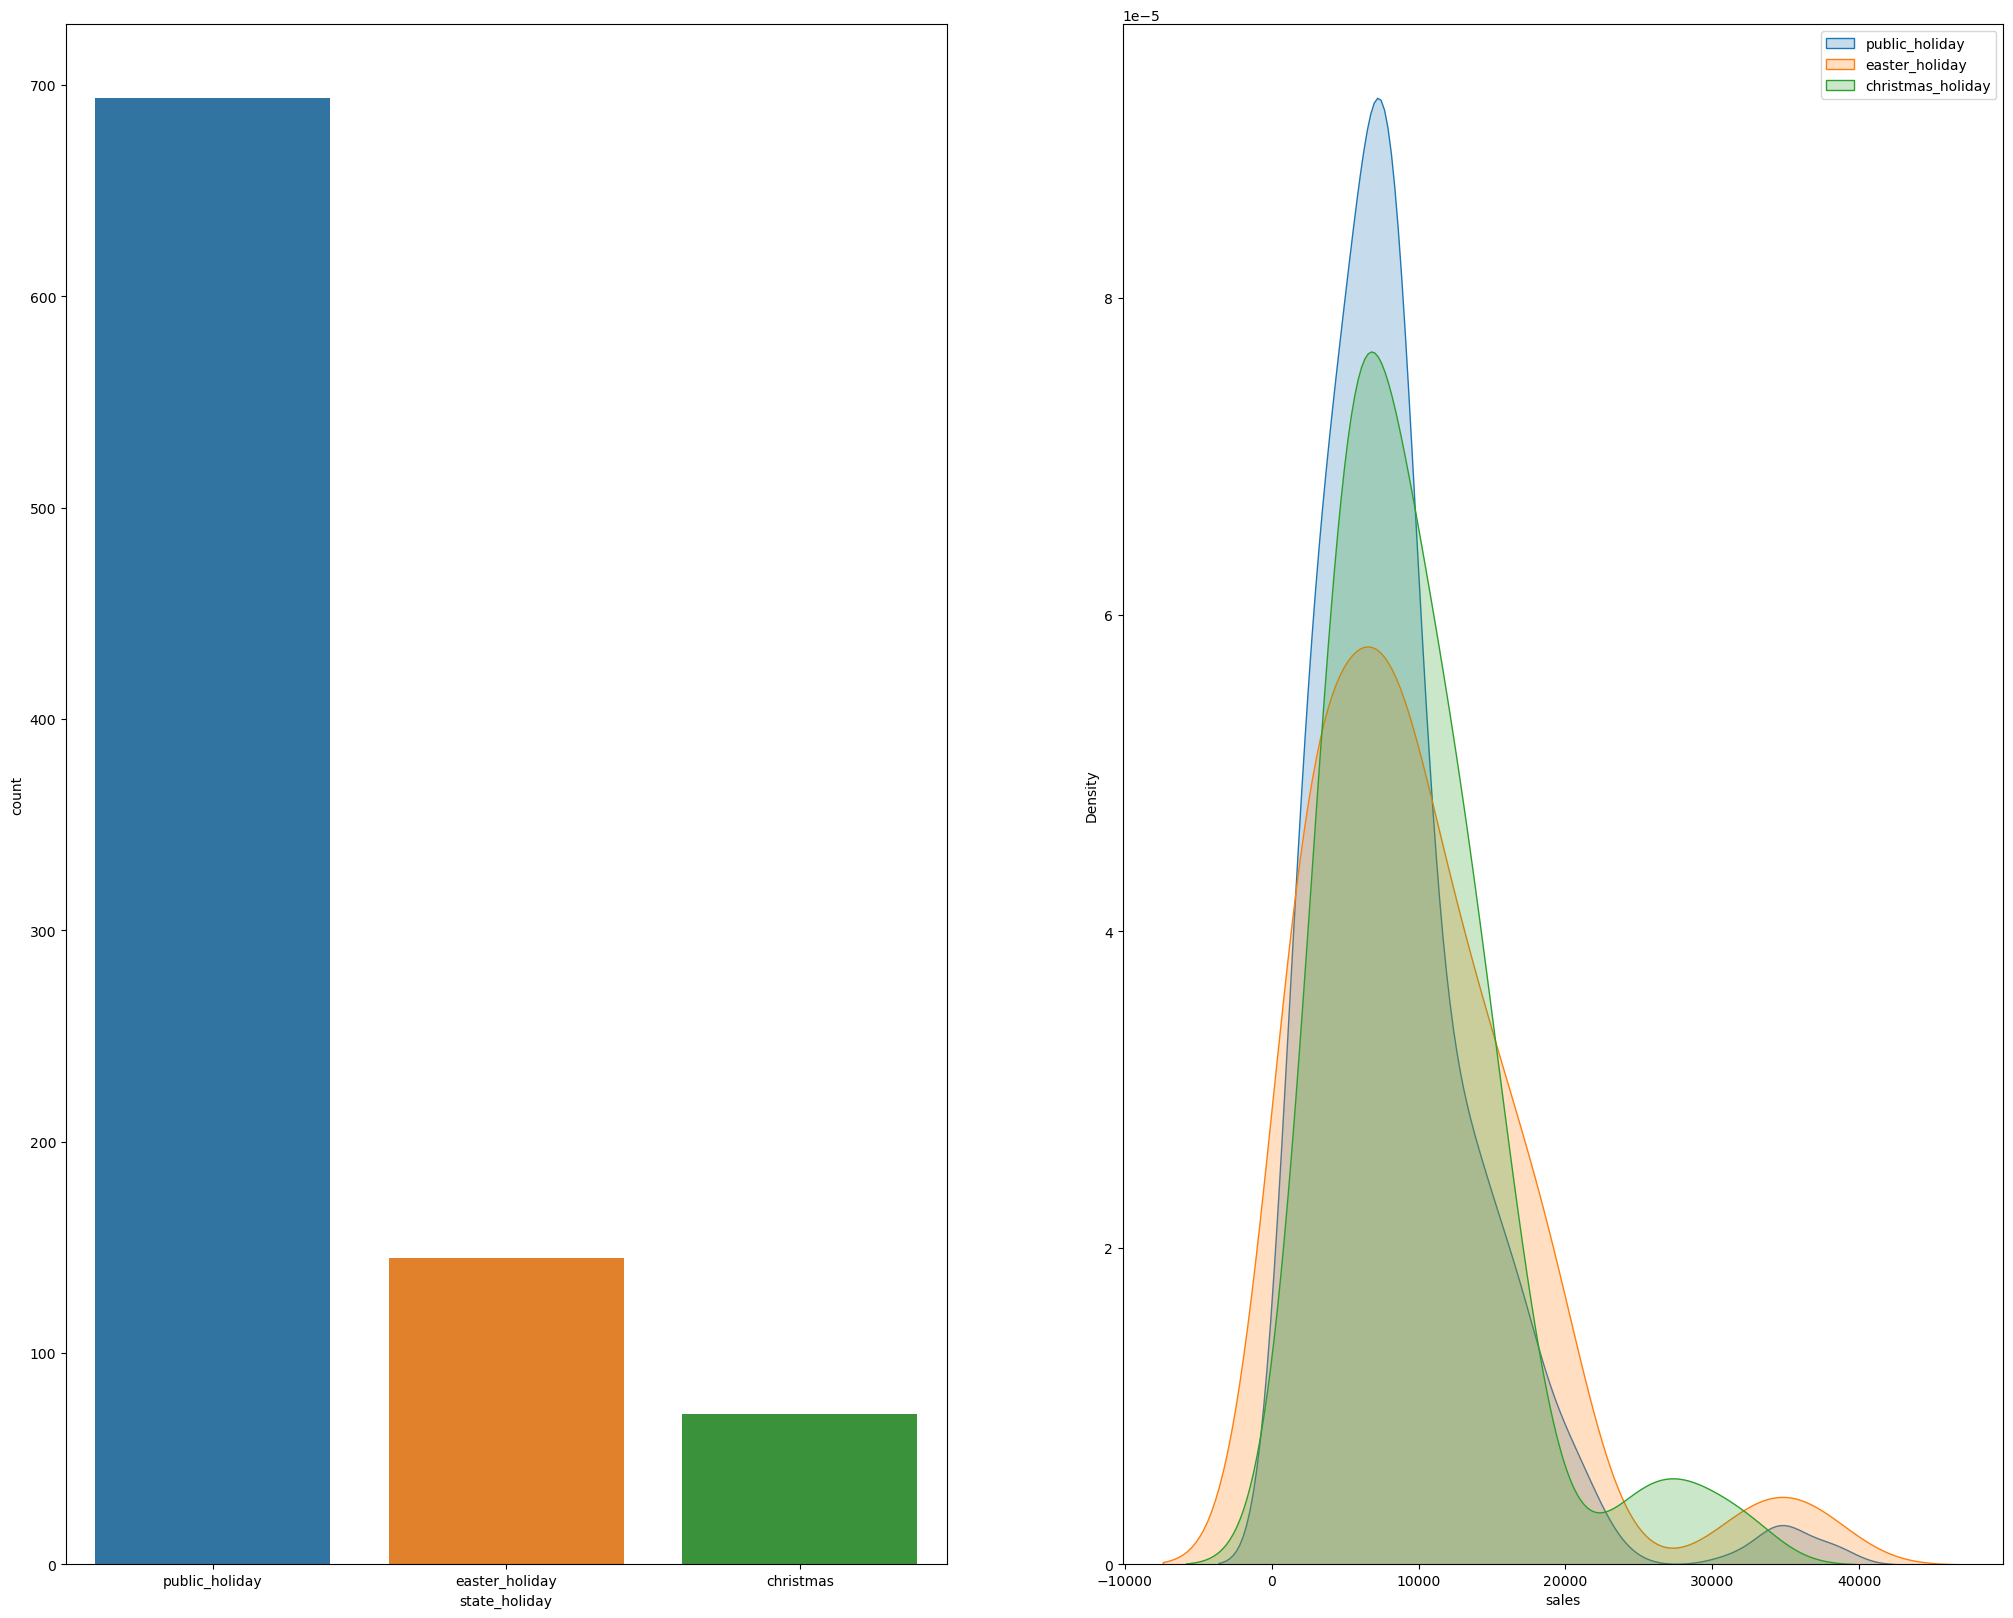

In [73]:
plt.figure(figsize=(25,20))
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(1,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday', fill=True)
plt.legend()

In [74]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

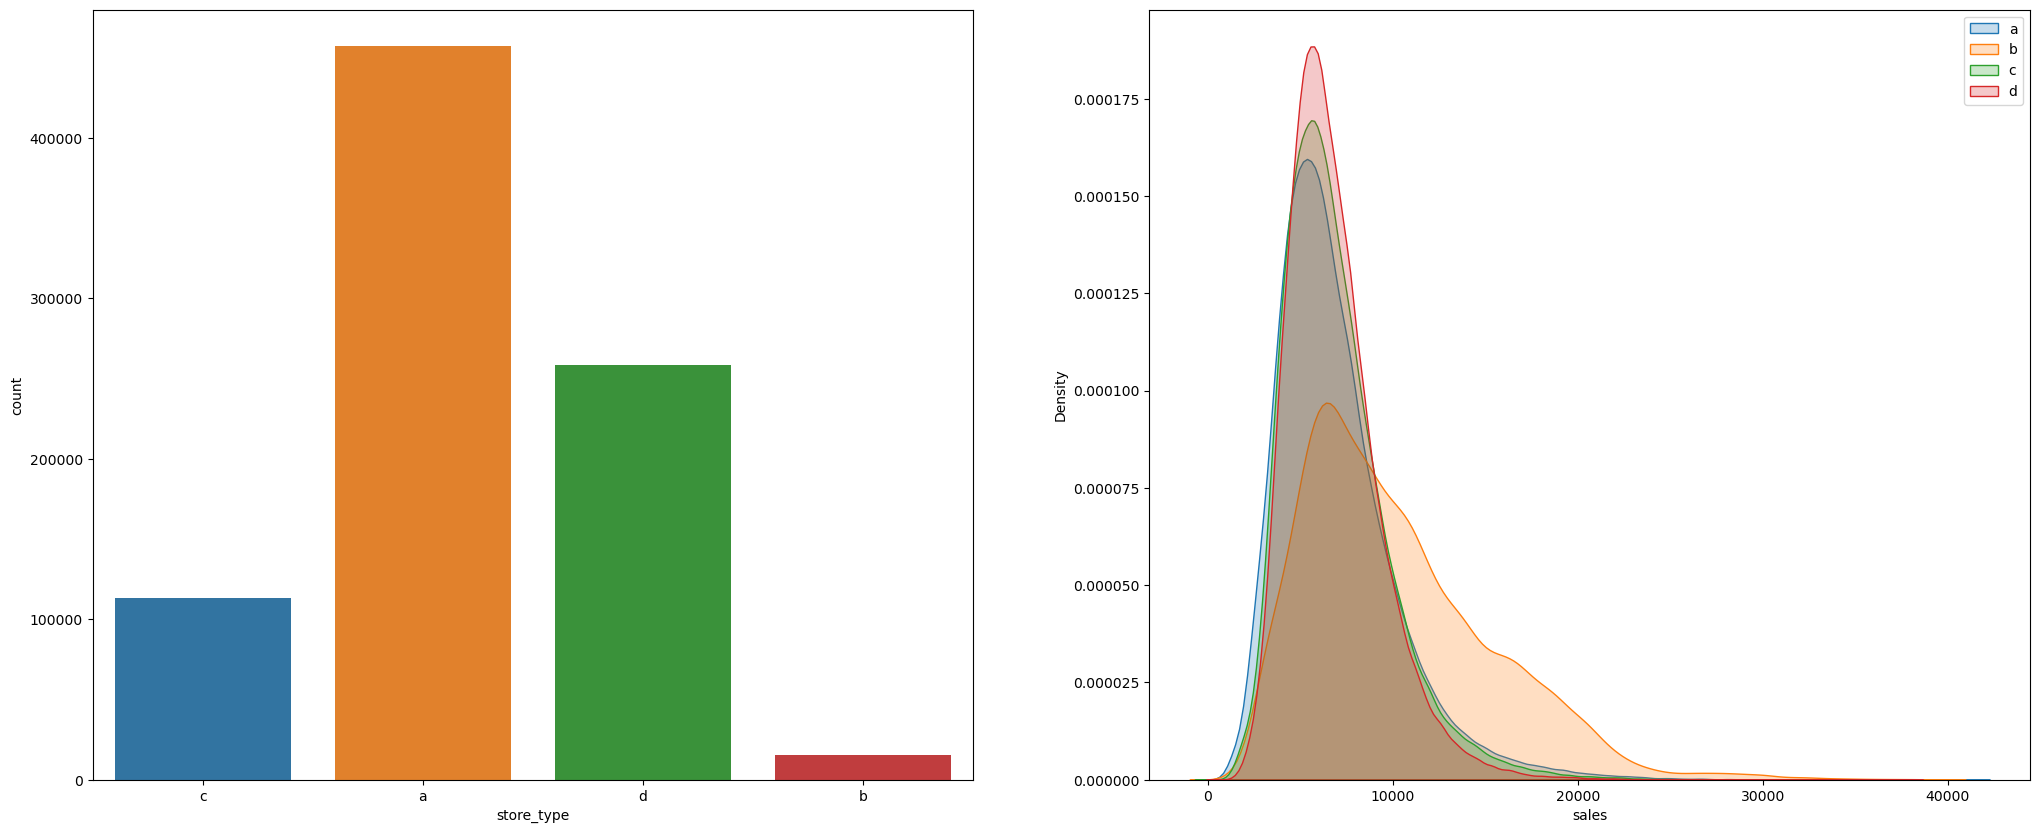

In [75]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
sns.countplot(x='store_type', data=df4)

plt.subplot(1,2,2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()

In [76]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

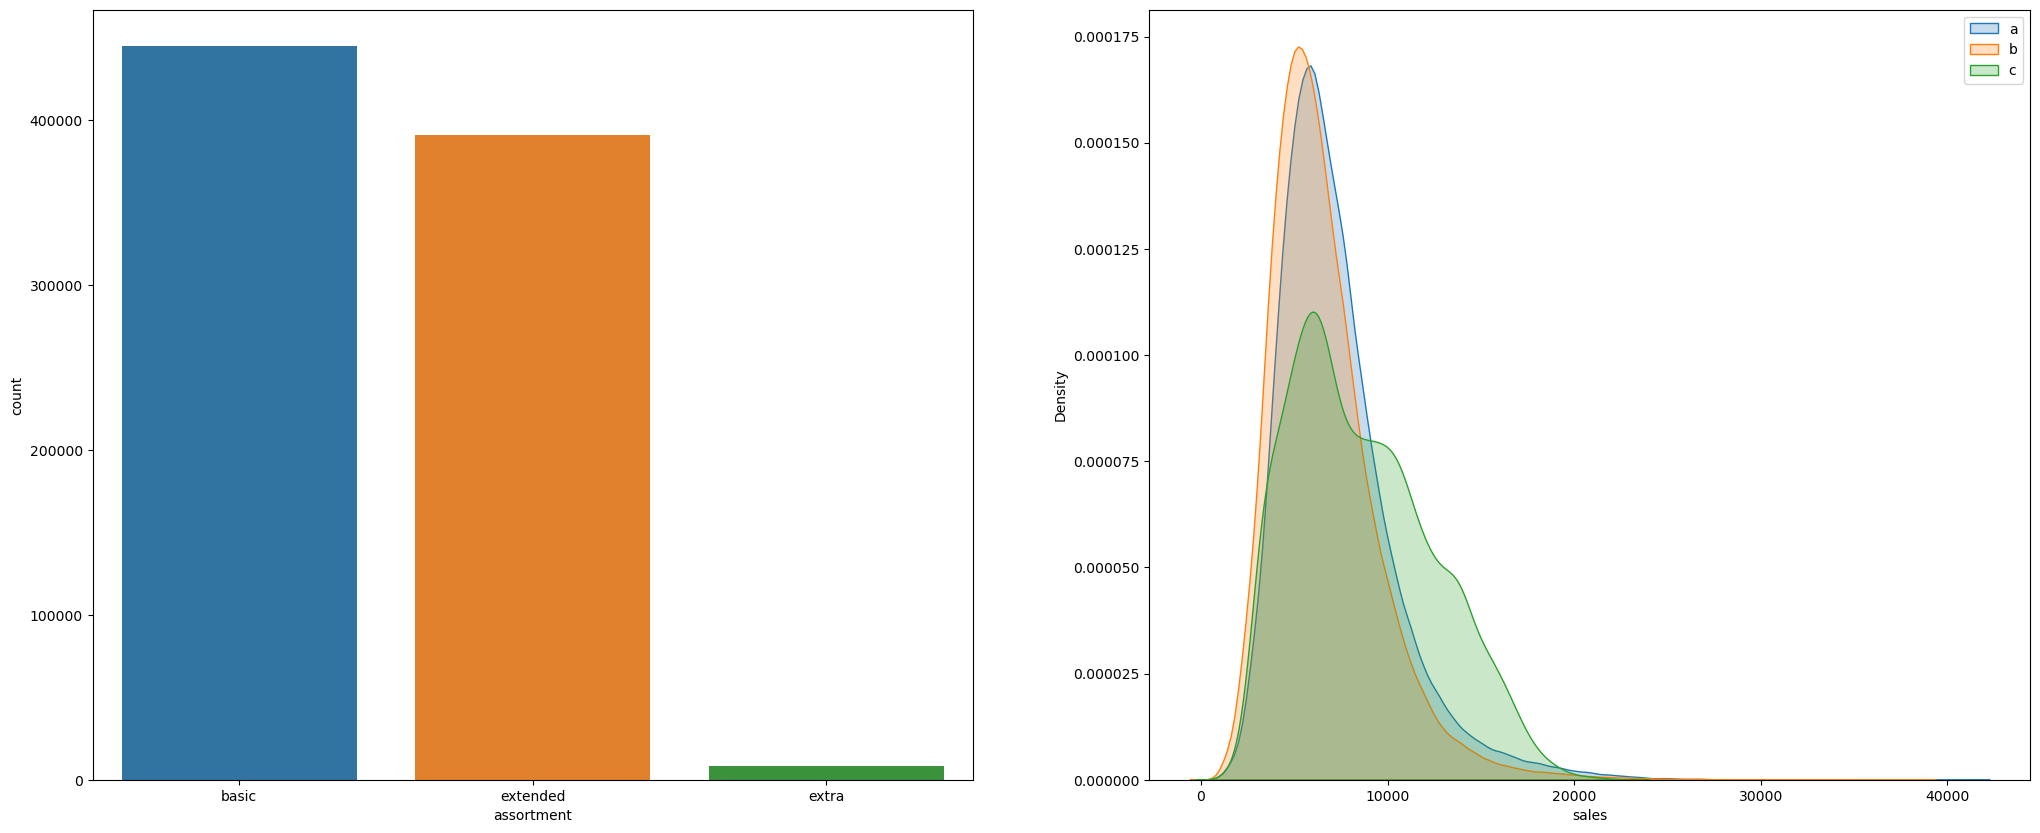

In [77]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
sns.countplot(x='assortment', data=df4)

plt.subplot(1,2,2)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='a', fill=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='b', fill=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='c', fill=True)
plt.legend()

## 4.2 Analise bivariada

### H1 Lojas com maior assortimento deveriam vender mais

<Axes: xlabel='year_week'>

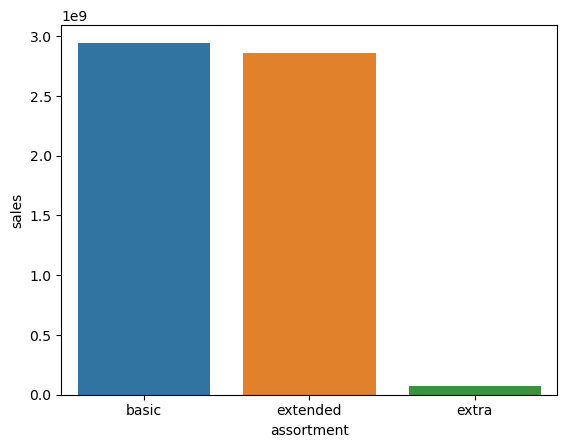

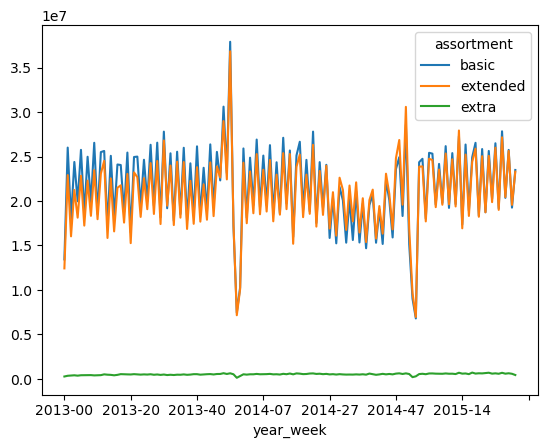

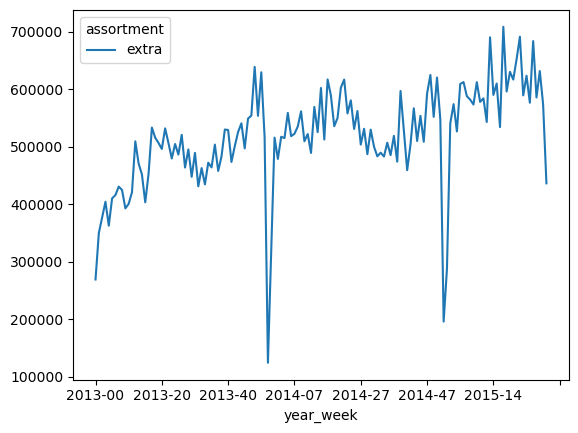

In [80]:
aux1 = df4[['assortment', 'sales']].groupby( "assortment" ).sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week',"assortment"] ).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot() #transformou os valores de assortment em colunas

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot(index='year_week',columns='assortment',values='sales').plot() #transformou os valores de assortment em colunas

Hipotese negada, visto que as lojas que menos vendem são as extras, e as basics por pouco se sobressai do extended

### H2 Lojas com competidores mais próximos deveriam vender menos

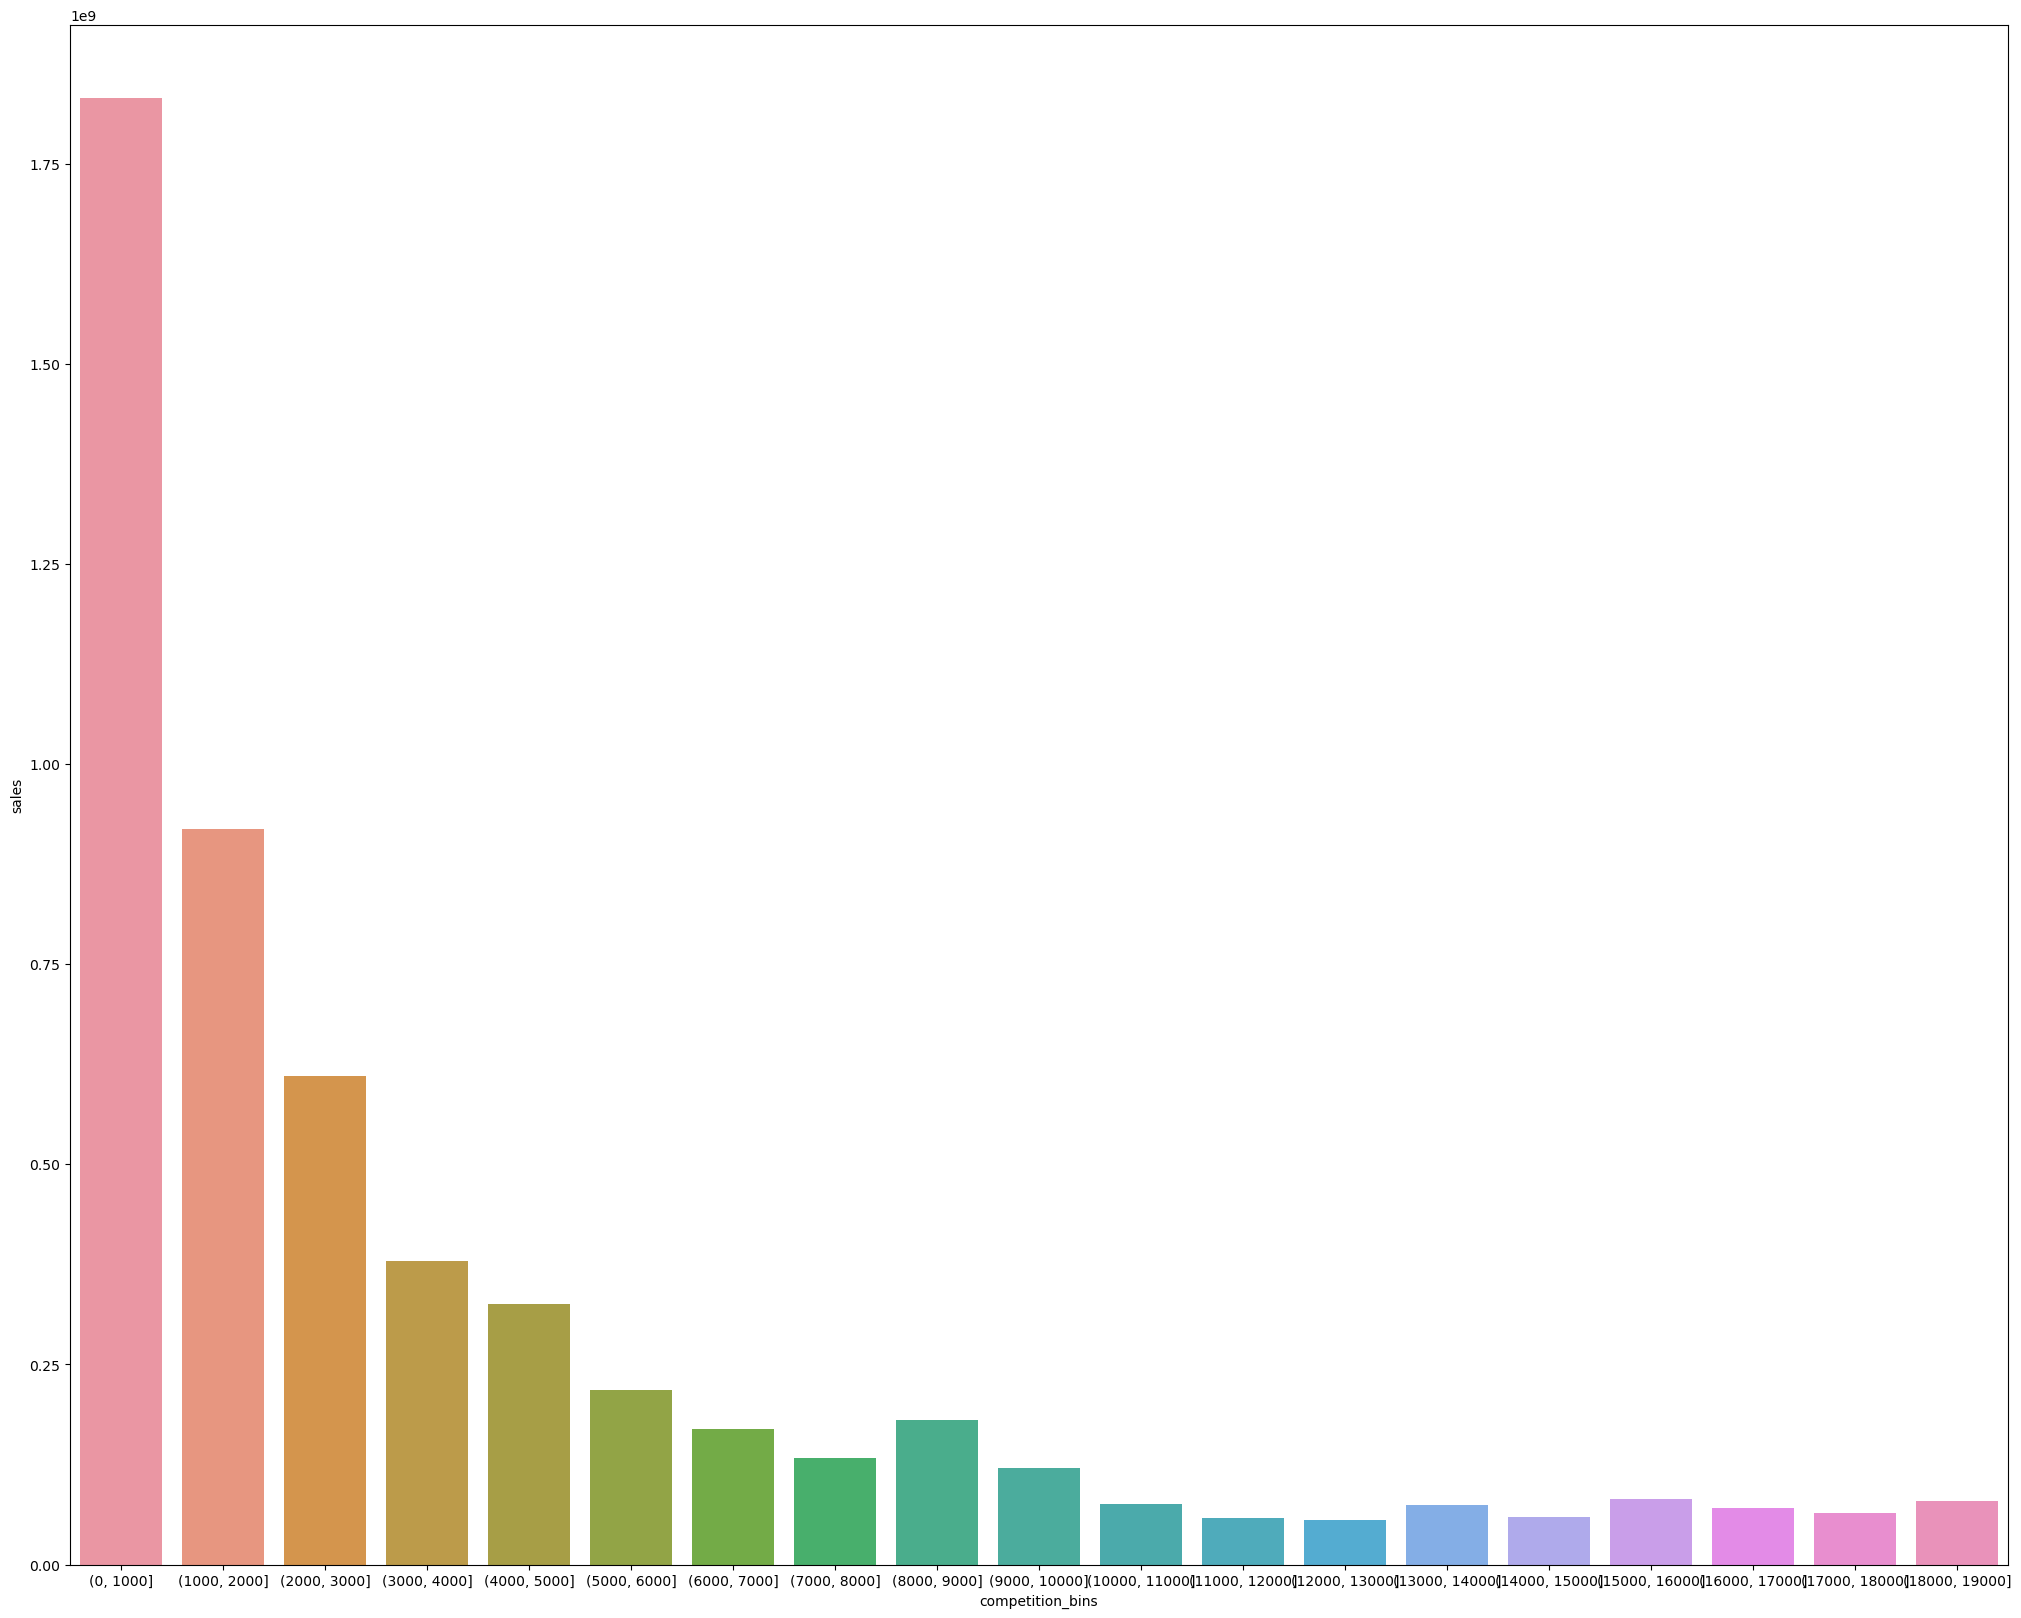

In [83]:
plt.figure(figsize=(25,20))
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list(range(0,20000,1000))
aux1['competition_bins'] = pd.cut(aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_bins', 'sales']].groupby( 'competition_bins' ).sum().reset_index()

sns.barplot(x='competition_bins', y='sales', data=aux2)
plt.show()

<Axes: xlabel='competition_distance', ylabel='sales'>

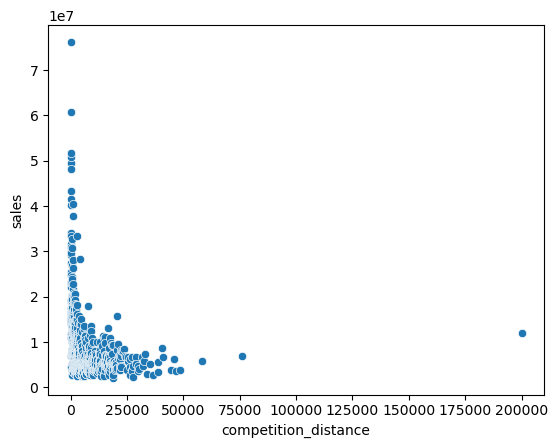

In [84]:
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

<Axes: >

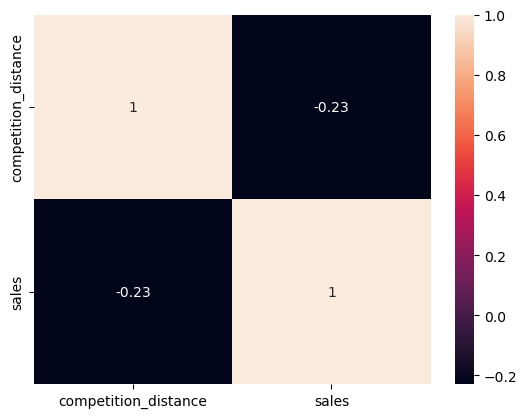

In [85]:
aux1.drop('competition_bins', axis=1, inplace=True)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

Hipotese negada, visto que lojas com competidores mais proximos acabam vendendo mais

### H3 Lojas com competidores a mais tempo devem vender mais

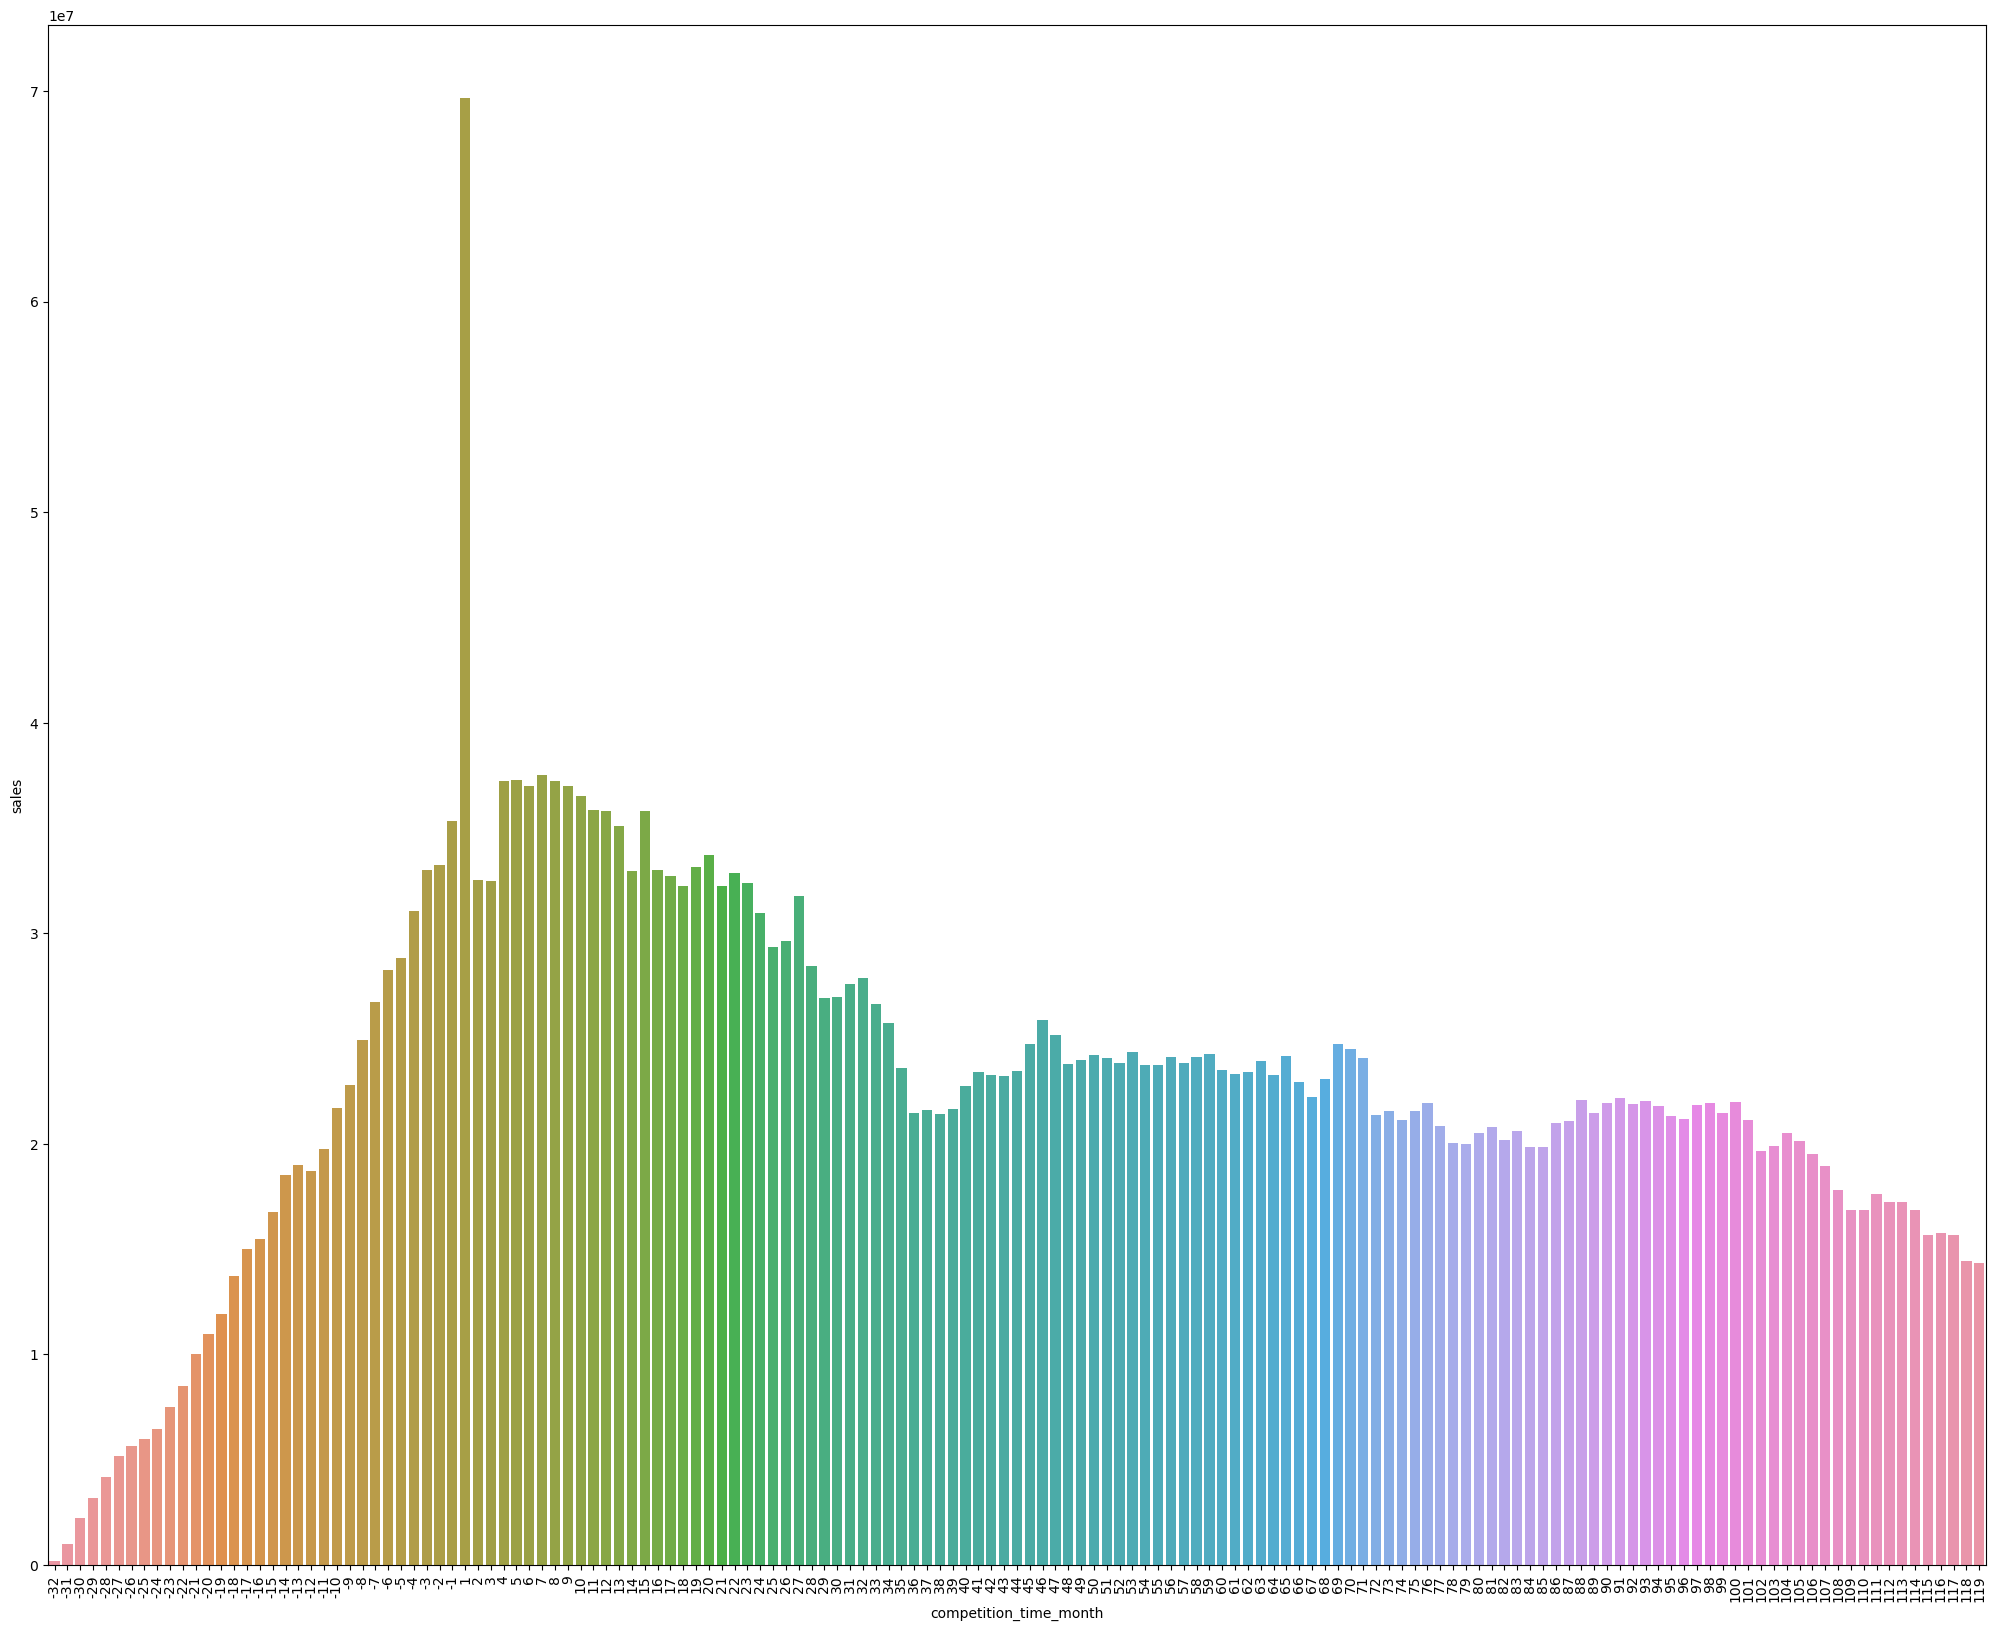

In [88]:
plt.figure(figsize=(25,20))
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

sns.barplot(x='competition_time_month', y='sales', data=aux2)

plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='competition_time_month', ylabel='sales'>

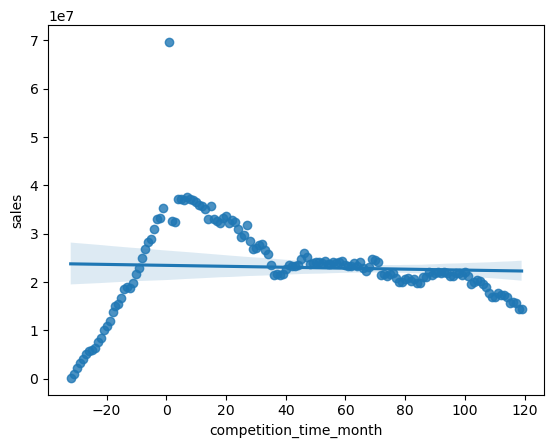

In [89]:
sns.regplot(x='competition_time_month', y='sales', data=aux2)

<Axes: >

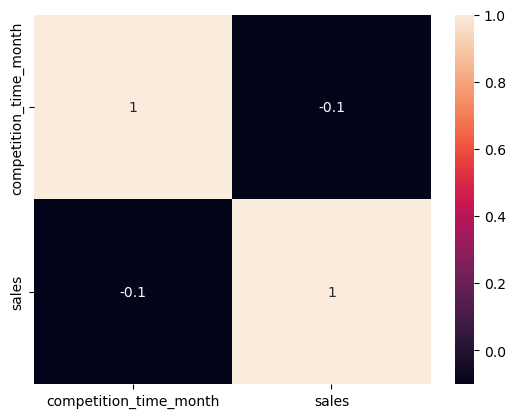

In [90]:
sns.heatmap(aux1.corr(method="pearson"), annot=True)

Hipotese negada, lojas com competidores mais cedo vendem mais, e lojas que não tem competidores vendem menos

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais

<Axes: >

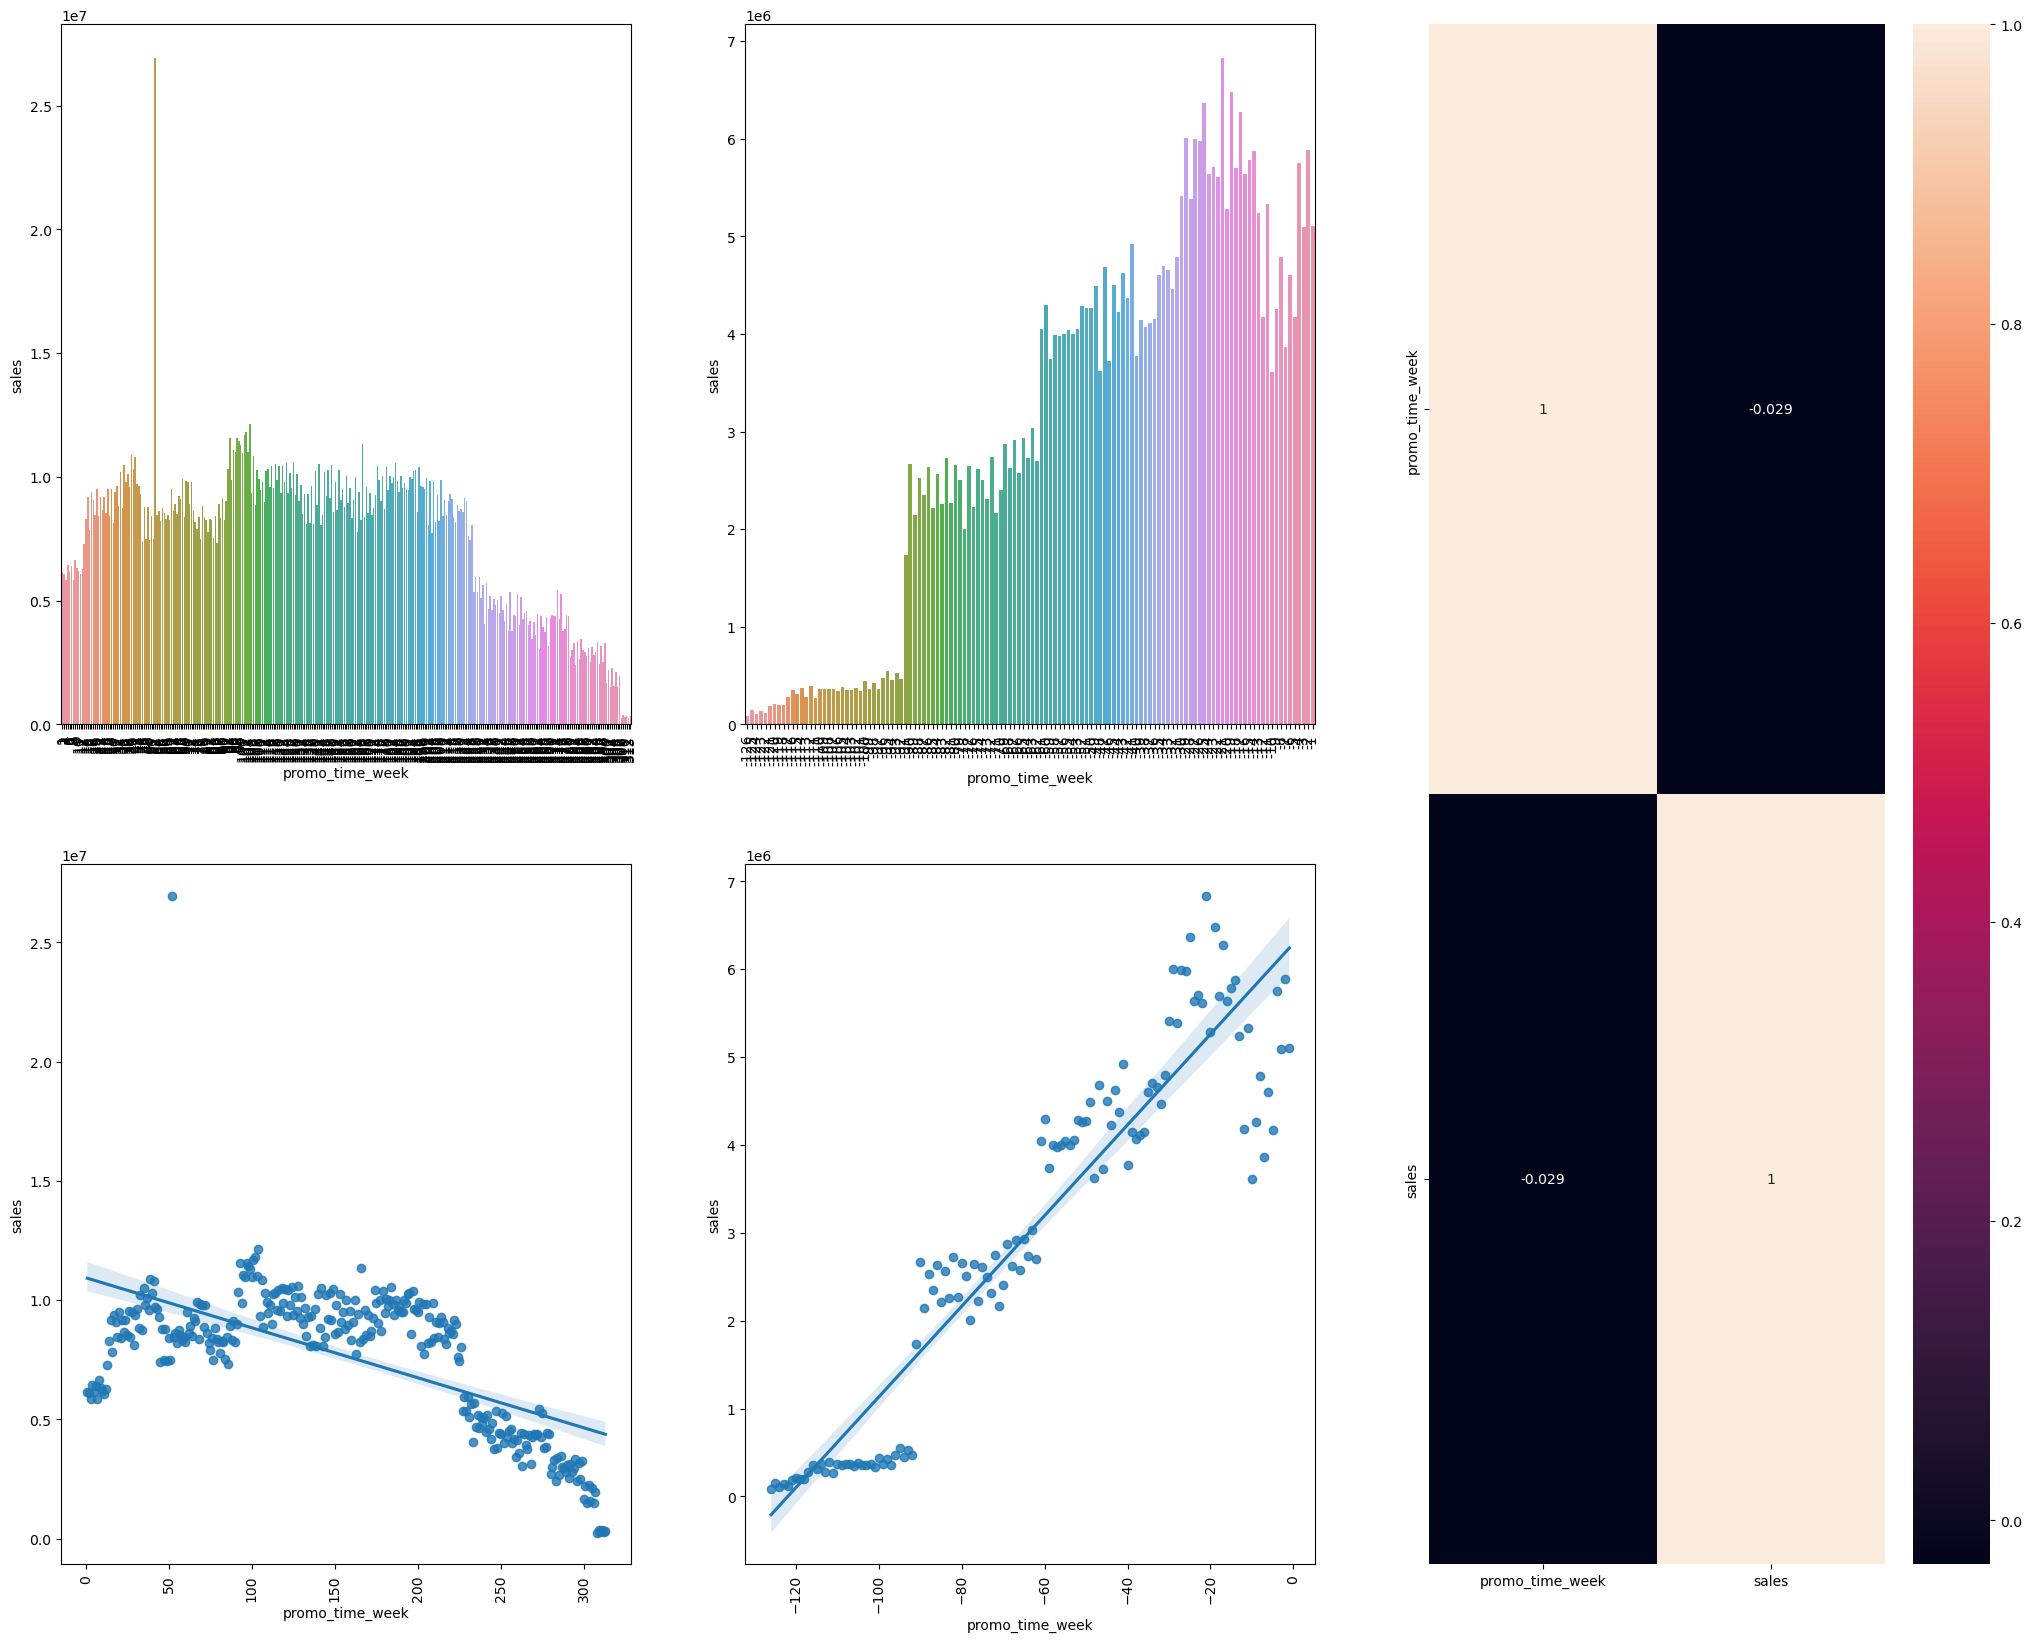

In [93]:
aux1 = df4[['promo_time_week', "sales"]].groupby( "promo_time_week" ).sum().reset_index()

plt.figure(figsize=(25,20))

grid = GridSpec( 2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendida
sns.barplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
sns.regplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipotese provada como falsa, porque as lojas deixam de vender depois de um certo período de promoção

### H6 Lojas com promoções consecutivas deveriam vender mais

In [96]:
df4[["promo", "promo2", "sales"]].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


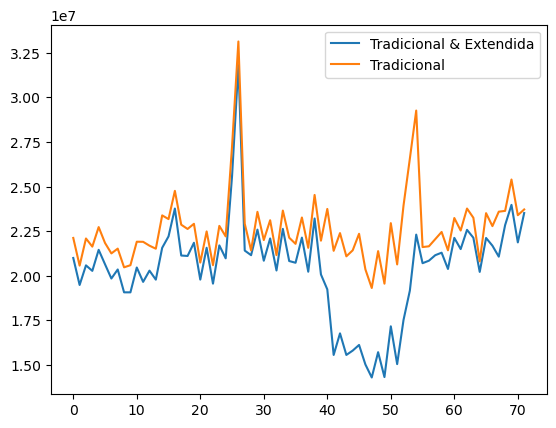

In [97]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend( labels=["Tradicional & Extendida", "Tradicional"])

Hipotese negada lojas com promocoes consecutivas vendem menos

### H7 Lojas abertas durante o feriado de natal deveriam vender mais

<Axes: xlabel='state_holiday', ylabel='sales'>

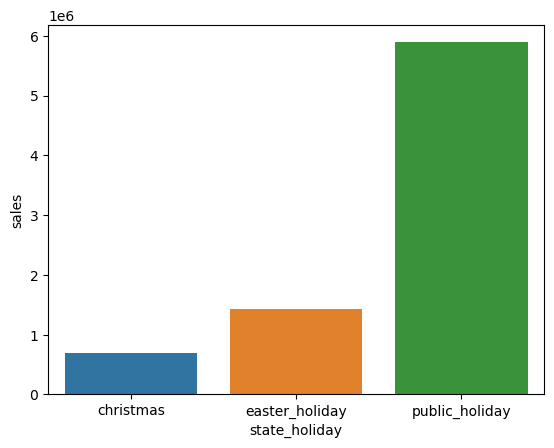

In [100]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2)

<Axes: xlabel='year', ylabel='sales'>

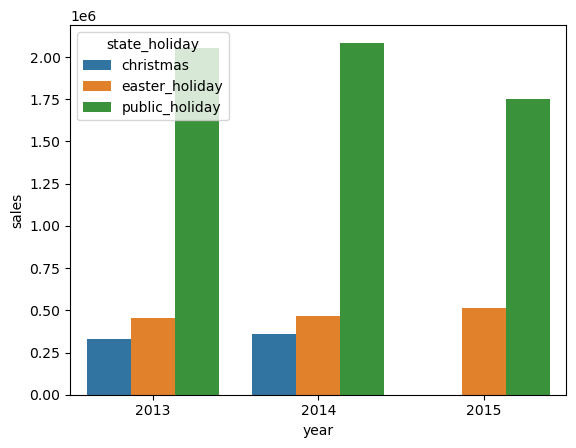

In [101]:
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue = 'state_holiday',data=aux3)

Hipotese falsa os feriados que mais vendem são os públicos

### H8 Lojas deveriam vender mais ao longo dos anos

<Axes: >

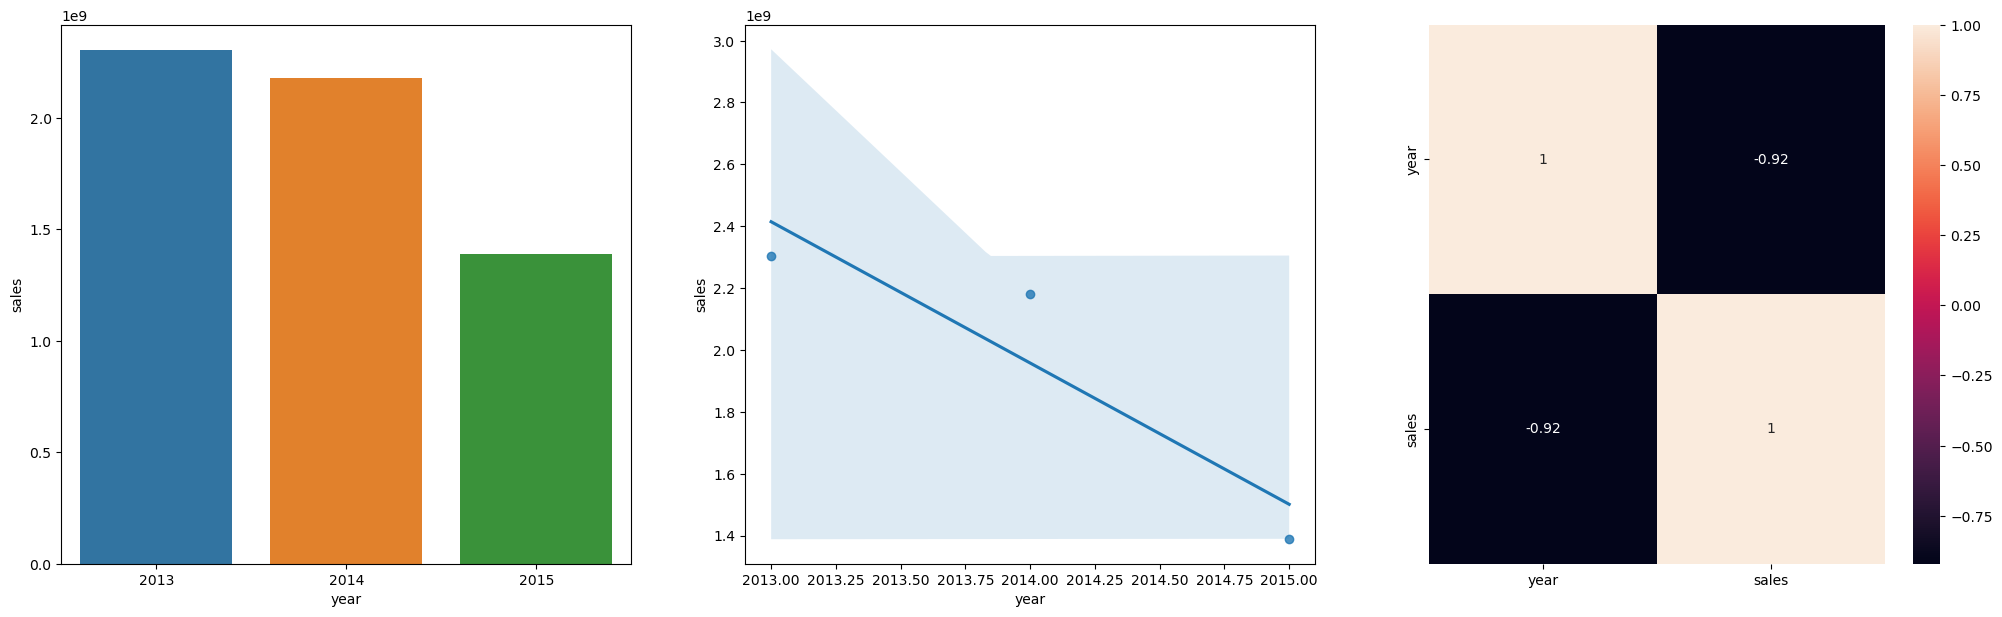

In [104]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

Esses dados podem estar com alguns problemas ja que 2015 está incompleto

Hipotese falsa: lojas devem vender menos ao longo dos anos

### H9 Lojas deveriam vender mais no segundo semestre

<Axes: >

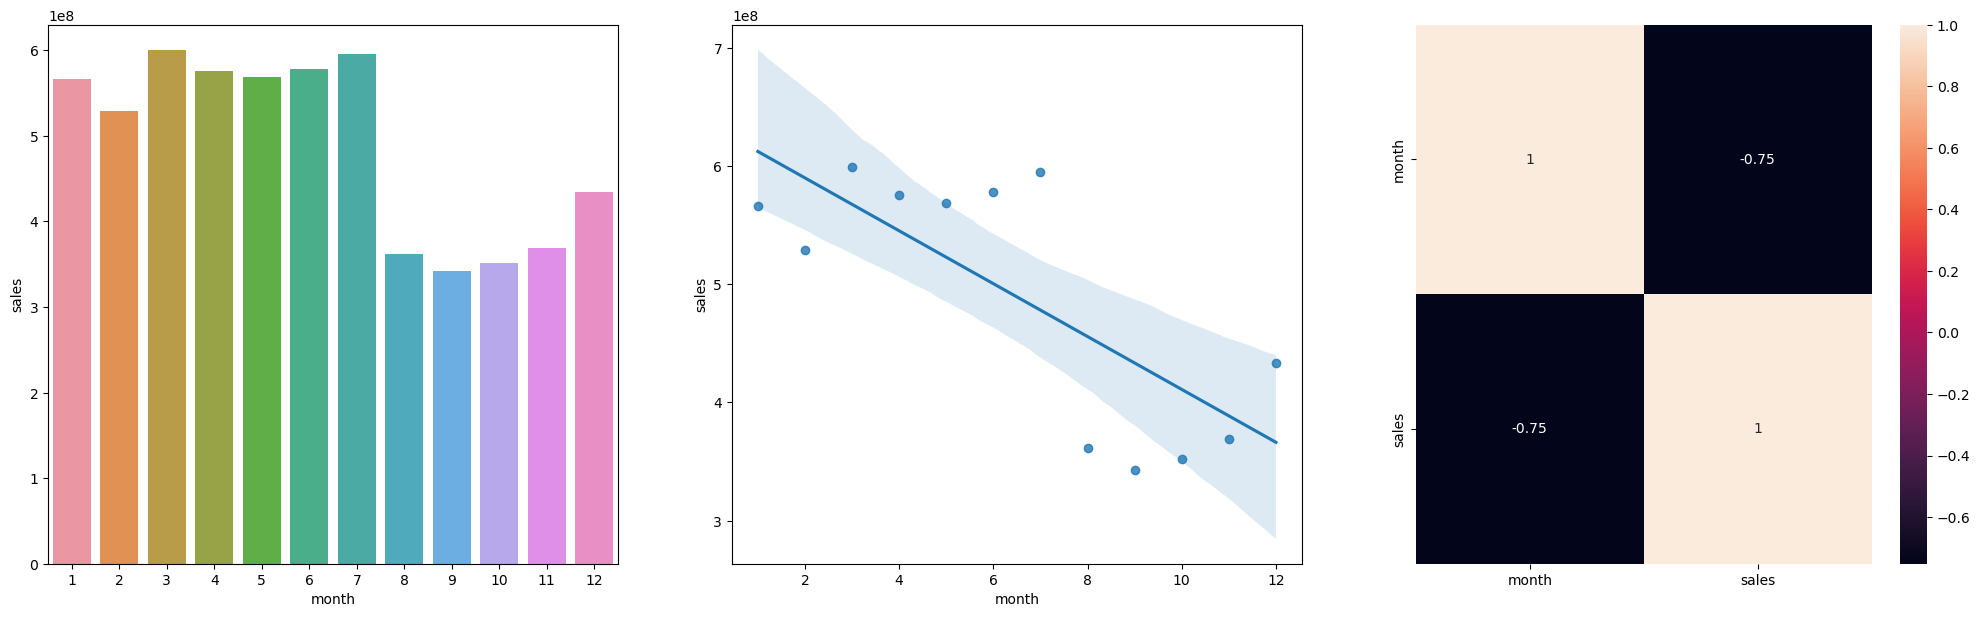

In [108]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipotese negada, com o andar do ano, a tendencia é de redução nas vendas

### H10 As lojas deveriam vender mais depois do dia 10 de cada mês

<Axes: >

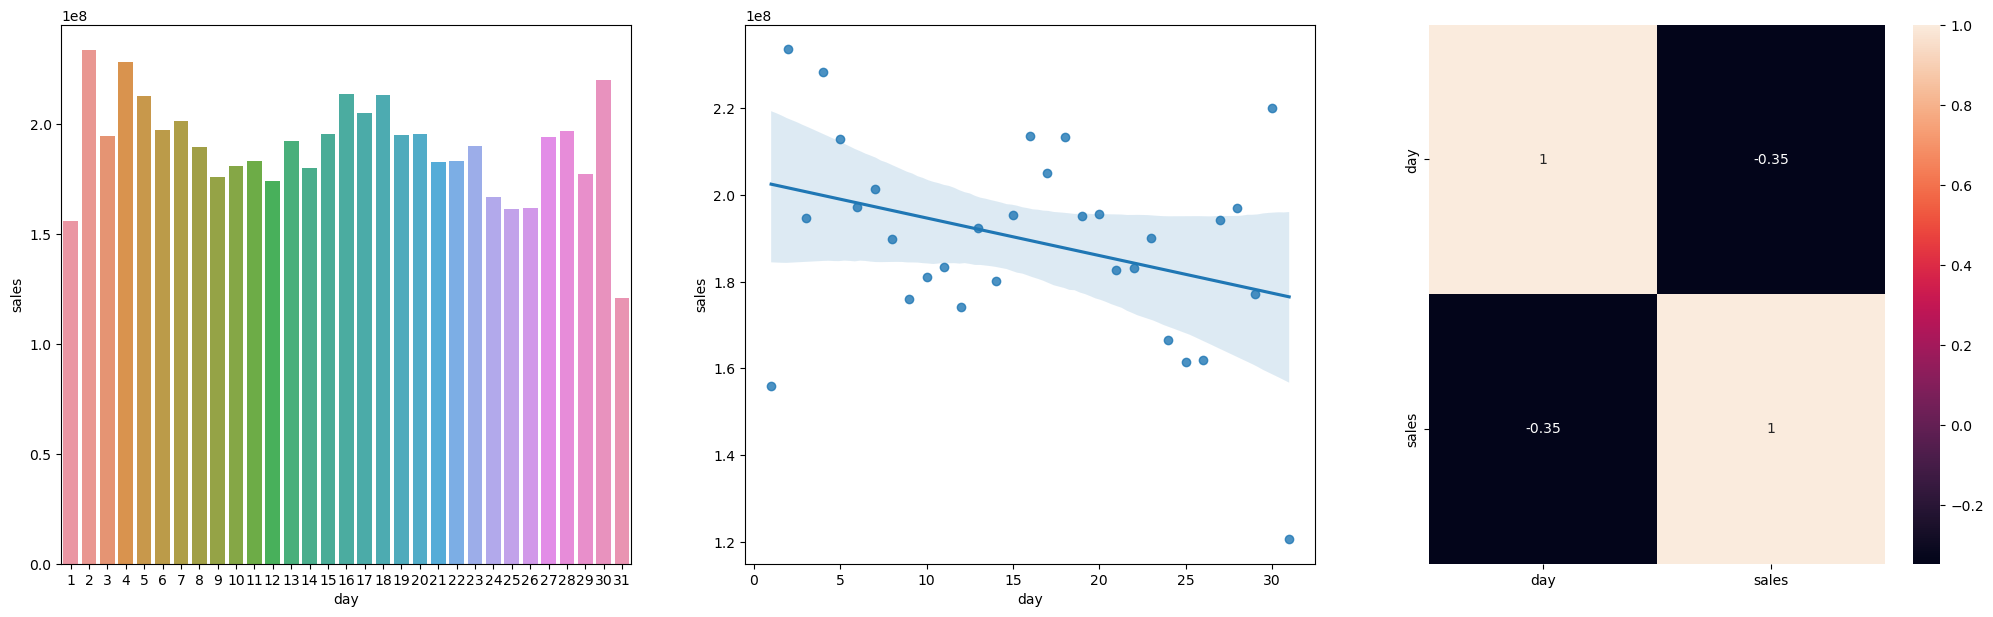

In [111]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipotese verdadeira, lojas vendem mais depois do dia 10

### H11 Lojas deveriam vender menos nos finais de semana

<Axes: >

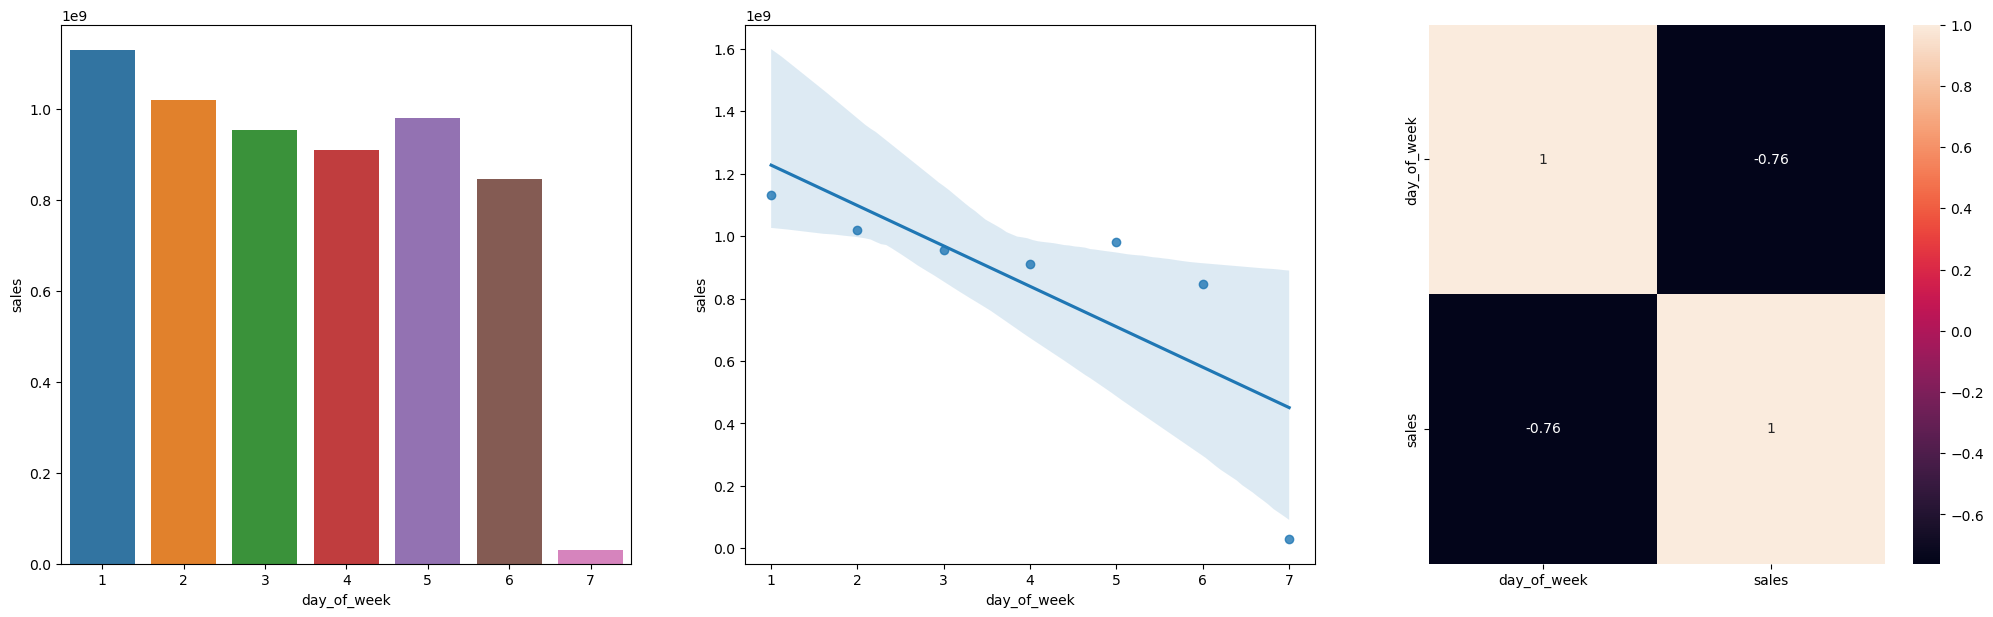

In [114]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipotese verdadeira, lojas tendem a vender menos nos finais de semana

### H12 Lojas deveriam vender menos durante os feriados escolares

<Axes: xlabel='month', ylabel='sales'>

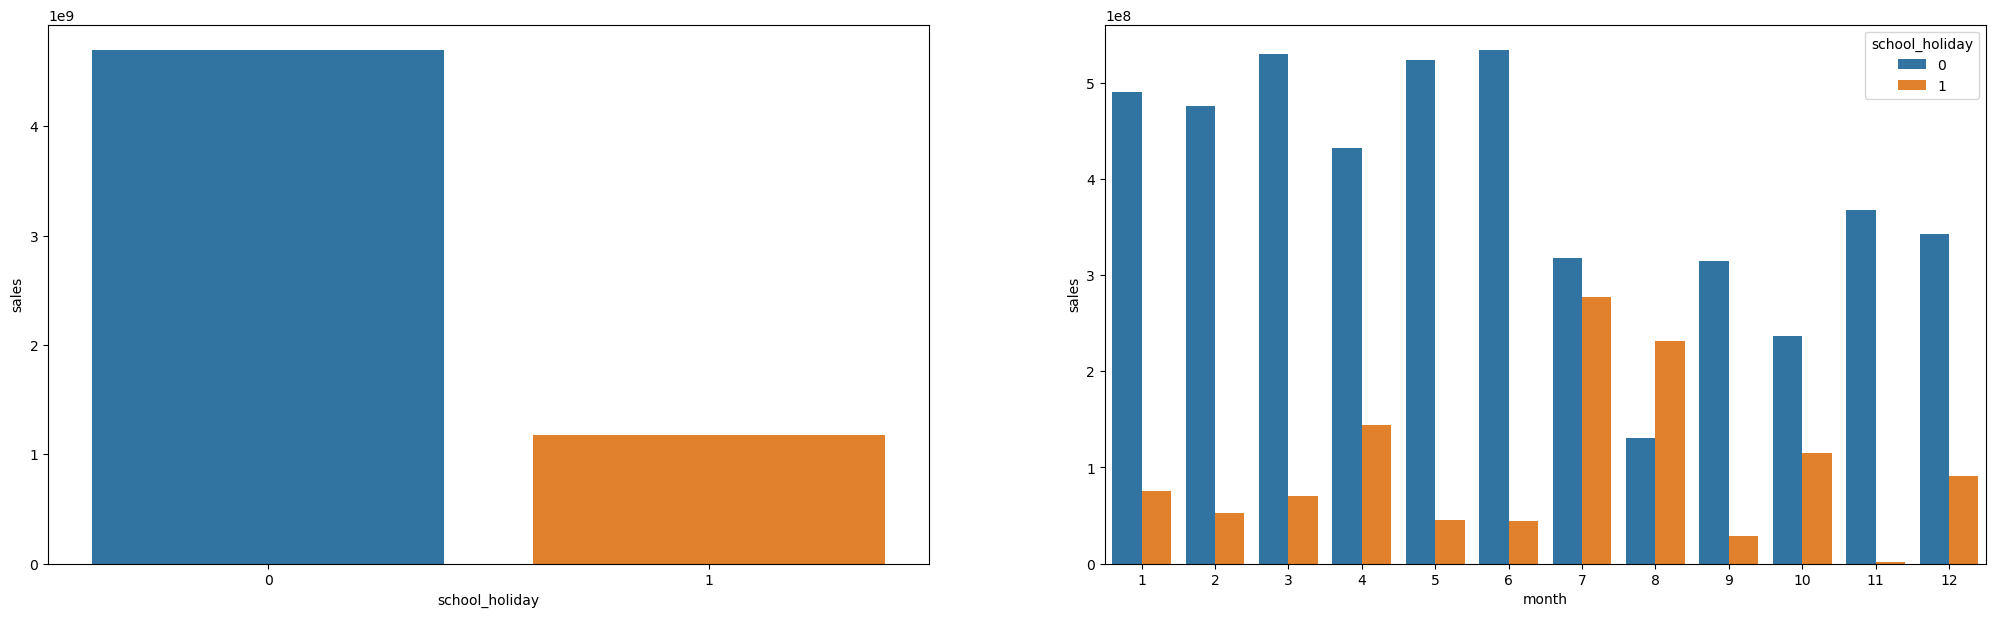

In [117]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2=df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2)

Afirmação verdadeira exceto em agosto

## 4.3 Analise multivariada

### 4.3.1 Atributos numéricos

<Axes: >

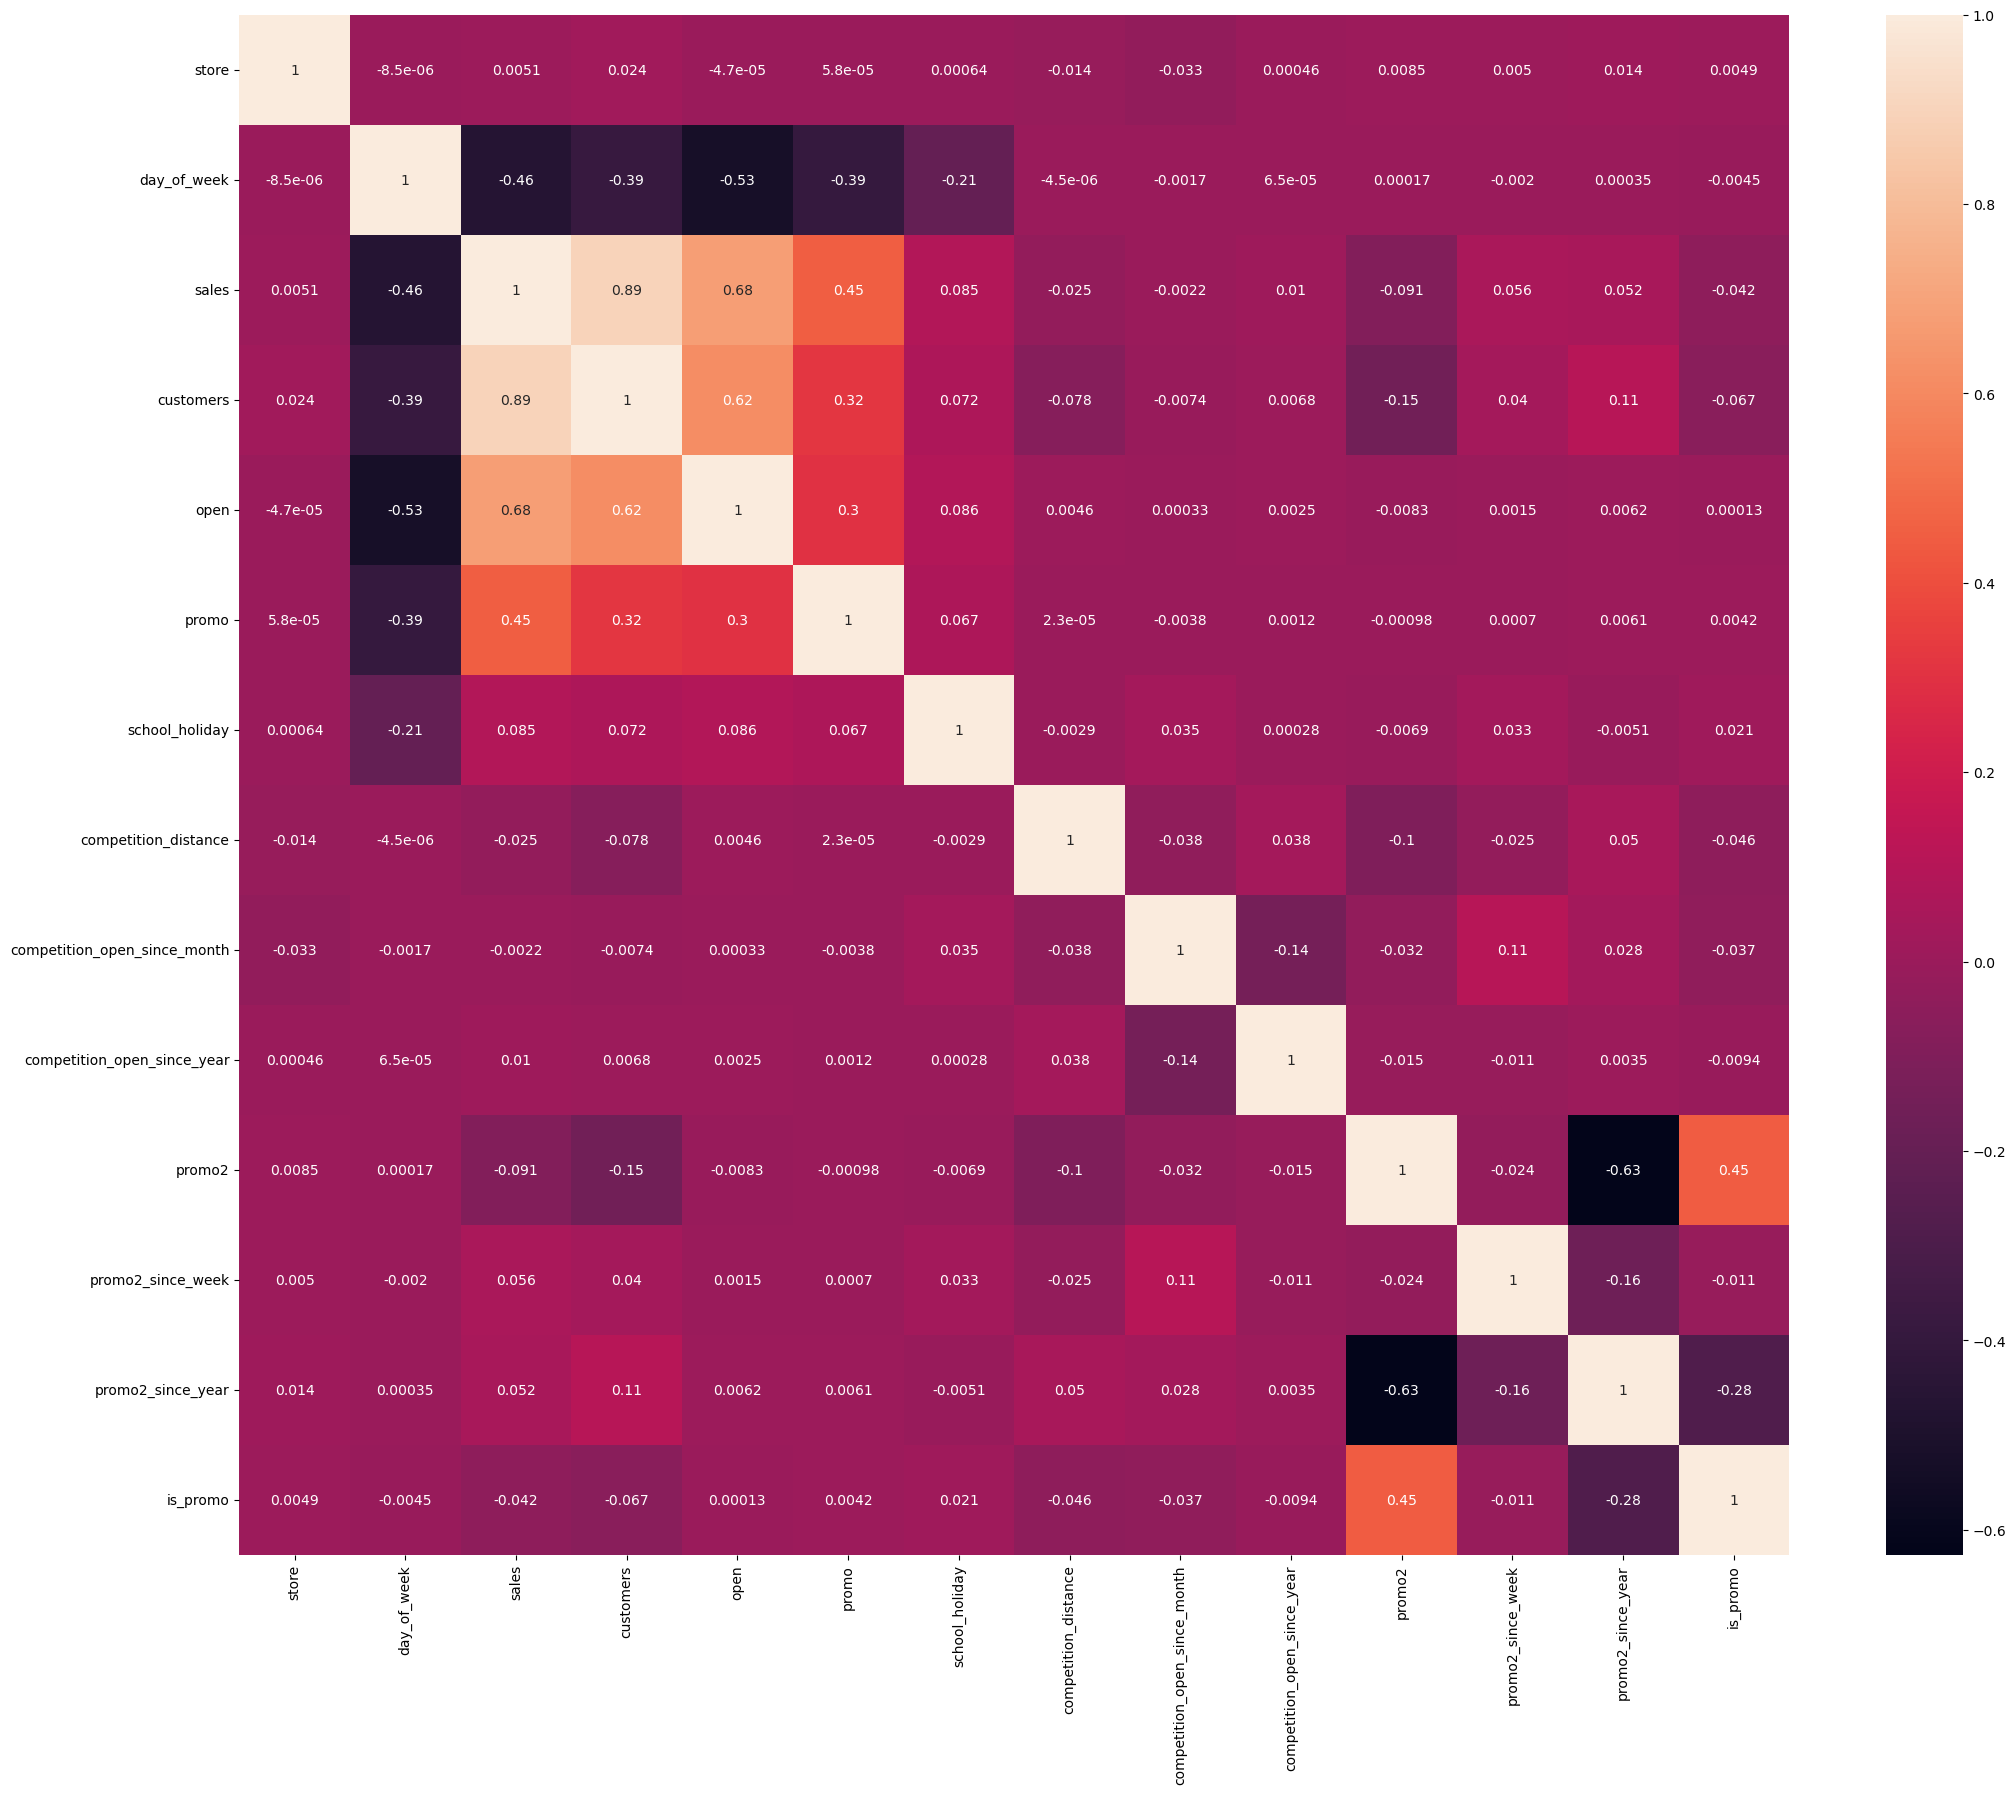

In [121]:
correlation = df_num.corr(method='pearson')
plt.figure(figsize=(25,20))
sns.heatmap(correlation, annot=True)

### 4.3.2 Atributos categóricos

In [123]:
a = df4.select_dtypes(include='object')

In [124]:
#aplicando cramer v
def cramer_v_bias(x, y):
    cm = pd.crosstab( x, y )
    n = cm.sum().sum()
    k, r = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - ((k-1)**2 / (n-1))
    rcorr = r - ((r-1)**2 / (n-1))

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


In [125]:
a1 = cramer_v_bias( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v_bias( a['state_holiday'], a['store_type'] )
a3 = cramer_v_bias( a['state_holiday'], a['assortment'] )

a4 = cramer_v_bias( a['store_type'], a['state_holiday'] )
a5 = cramer_v_bias( a['store_type'], a['store_type'] )
a6 = cramer_v_bias( a['store_type'], a['assortment'] )

a7 = cramer_v_bias( a['assortment'], a['state_holiday'] )
a8 = cramer_v_bias( a['assortment'], a['store_type'] )
a9 = cramer_v_bias( a['assortment'], a['assortment'] )

<Axes: >

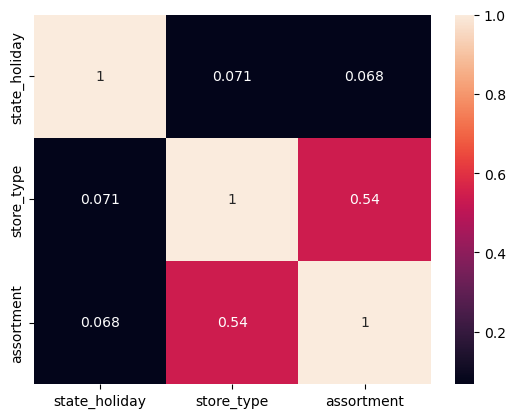

In [126]:
d = pd.DataFrame( {'state_holiday': [a1,a2,a3], 
              'store_type': [a4,a5,a6], 
              'assortment': [a7,a8,a9]} )

sns.heatmap(d.set_index(d.columns), annot=True)

# 5.0 Preparação dos dados

In [128]:
df5 = df4.copy()

## 5.1 Normalização
Não há variaveis que tendem a normal

## 5.2 Rescaling

In [131]:
a = df5.select_dtypes( include=['int64', 'float64'] )

In [132]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


In [133]:
rs = RobustScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform( df5[["competition_distance"]].values )

#competition time month
df5['competition_time_month'] = rs.fit_transform( df5[["competition_time_month"]].values )

In [134]:
mms = MinMaxScaler()

#promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Transformação

### 5.3.1 Encoding

In [137]:
#state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [138]:
#store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [139]:
#assortment
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [141]:
df5['sales'] = np.log1p(df5['sales'])

<Axes: xlabel='sales', ylabel='Count'>

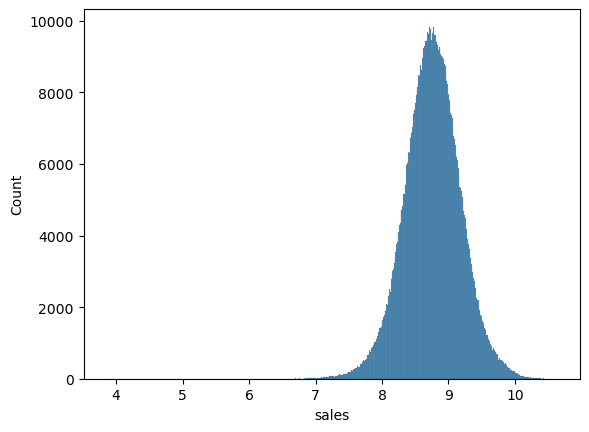

In [142]:
sns.histplot(df5['sales'])

### 5.3.2 Nature transformation

In [144]:
#day of week
df5['dow_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['dow_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
#week of year
df5['woy_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['woy_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# 6.0 Seleção de variáveis

In [146]:
df6 = df5.copy()

## 6.2 Transformar em teste e treino

In [148]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,dow_sin,dow_cos,month_sin,month_cos,day_sin,day_cos,woy_sin,woy_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [149]:
#deleção de variáveis que sofreram derivação
cols_drop = ['week_of_year', 'day_of_week', 'month', 'day', 'promo_since', 'competition_since', 'year_week']
df6.drop(cols_drop, axis=1, inplace=True)

In [150]:
X_train = df6[df6['date'] < '2015-06-19'] #6 semanas dada a lógica do problema
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Implementação do boruta

In [152]:
#x_train_n = X_train.drop(['sales', 'date'], axis=1).values
#y_train_n = y_train.values.ravel()

In [153]:
#rf = RandomForestRegressor(n_jobs=-1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [154]:
#X_train_fs = X_train.drop(['sales', 'date'], axis=1)
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = list(X_train_fs.iloc[:, cols_selected].columns)
#cols_not_selected = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [155]:
#cols_selected_boruta

In [156]:
#cols_not_selected

## 6.3 Seleção manual

In [158]:
cols_selected_boruta = ['store',
                'promo',
                'store_type',
                'assortment',
                'competition_distance',
                'competition_open_since_month',
                'competition_open_since_year',
                'promo2',
                'promo2_since_week',
                'promo2_since_year',
                'competition_time_month',
                'promo_time_week',
                'dow_sin',
                'dow_cos',
                'month_cos',
                'day_sin',
                'day_cos',
                'woy_cos',
                "year",
                "sales"]

# 7.0 Modelos de ML

In [160]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [161]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))
    

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse}, index=[0])

## 7.1 Modelo de Média

In [163]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how="left", on='store')
yhat_baseline = aux1["predictions"]

#performance
baseline_result = ml_error( "Average Model", np.expm1(y_test), np.expm1(yhat_baseline))

In [164]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Modelo Regressão linear

In [166]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2.377912e-11,3.198566e-15,3.588423e-11


## 7.3 Modelo Regressão linear regularizada

In [265]:
# modelo
la = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_la = la.predict(x_test)

#performance
ml_error("Lasso Regression", np.expm1(y_test), np.expm1(yhat_la))

,Model Name,MAE,MAPE,RMSE
0,Lasso Regression,135.593579,0.017845,229.266253
